In [5]:
!pip install pyDOE

In [2]:
import tensorflow as tf
#import tensorflow_probability as tfp
import datetime, os
#hide tf logs 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'  # or any {'0', '1', '2'} 
#0 (default) shows all, 1 to filter out INFO logs, 2 to additionally filter out WARNING logs, and 3 to additionally filter out ERROR logs
import scipy.optimize
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import seaborn as sns 
import codecs, json

# generates same random numbers each time
np.random.seed(1234)
tf.random.set_seed(1234)

print("TensorFlow version: {}".format(tf.__version__))

TensorFlow version: 2.8.0


$\frac{\partial p(x,t)}{\partial t} = \frac{\partial}{\partial x}\left[\frac{m\omega^2}{\gamma} x \,p(x,t) + D \frac{\partial p(x,t)}{\partial x}\right] \qquad A= \frac{m\omega^2}{\gamma}$ 

# *Data Prep*

Training and Testing data is prepared from the solution file

In [6]:
from scipy.stats import multivariate_normal
#getting collocation points
x_lower = -1
x_upper = 1
y_lower = -1
y_upper = 1
x = np.linspace(x_lower, x_upper, 128)
y = np.linspace(y_lower, y_upper, 128)
t_lower = 0
t_upper = 0.5
t = np.linspace(t_lower, t_upper, 100)
X, Y, T = np.meshgrid(x, y ,t) 
psol=np.zeros((128, 128 ,len(t)))
pos = np.dstack((X[:,:,0], Y[:,:,0]))
rv = multivariate_normal(mean=[0.0 , 0.0], cov=[0.05 , 0.05])
psol[:][:,:,0] = rv.pdf(pos)

A=10
D=0.1

# *Test Data*

We prepare the test data to compare against the solution produced by the PINN.

In [7]:
''' X_u_test = [X[i],T[i]] [25600,2] for interpolation'''
X_p_test = np.hstack((X.flatten()[:, None], Y.flatten()[:, None], T.flatten()[:, None]))

# Domain bounds
low_bound = np.array([x_lower, y_lower ,t_lower]) 
up_bound = np.array([x_upper, y_upper, t_upper])

'''
stacked column wise!
   u = [c1 
        c2
        .
        .
        cn]

   u =  [25600x1] 
'''
p = psol.flatten('F')

In [44]:
def trainingdata(N_bc, N_ic, N_f):
    """ Initial Condition"""

    #Initial Condition -1 =< x =<1 and t = 0  
    all_ic_x = np.hstack((np.vstack(X[:,:,0][:,:,None]), np.vstack(Y[:,:,0][:,:,None]) ,np.vstack(T[:,:,0][:,:,None])))
    all_ic_p = np.vstack(psol[:][:,:,0][:,:,None])

    '''Boundary Conditions'''

    #Boundary Condition x = -1 and 0 =< t =<1
    bottomedge_xy = np.hstack((np.tile(X[0,:,0], len(t))[:,None], np.tile(Y[0,:,0], len(t))[:,None], np.hstack((np.tile(T[0,0,:][:,None], 128)))[:,None])) #L2
    bottomedge_p = np.tile(psol[:,-1,-1], len(t))[:,None]

    #Boundary Condition -1 < x < 1, y = 1 and 0 =< t =<1
    topedge_xy = np.hstack((np.tile(X[0,:,0], len(t))[:,None], np.tile(Y[-1,:,0], len(t))[:,None], np.hstack((np.tile(T[0,0,:][:,None], 128)))[:,None])) #L3
    topedge_p = np.tile(psol[:,-1,-1], len(t))[:,None]

    #Boundary Condition x = -1, -1 < y < 1 and 0 =< t =<1
    leftedge_xy = np.hstack((np.tile(X[:,0,0], len(t))[:,None], np.tile(Y[:,0,0], len(t))[:,None], np.hstack((np.tile(T[0,0,:][:,None], 128)))[:,None])) #L4
    leftedge_p = np.tile(psol[:,-1,-1], len(t))[:,None]

    #Boundary Condition x = 1, -1 < y < 1 and 0 =< t =<1
    rightedge_xy = np.hstack((np.tile(X[:,-1,0], len(t))[:,None], np.tile(Y[:,0,0], len(t))[:,None], np.hstack((np.tile(T[0,0,:][:,None], 128)))[:,None])) #L5
    rightedge_p = np.tile(psol[:,-1,-1], len(t))[:,None]

    all_bc_x=np.vstack([bottomedge_xy, topedge_xy, leftedge_xy, rightedge_xy])
    # Reflecting conditions do not use the value of p
    #all_bc_p_train = np.vstack([bottomedge_p, topedge_p, rightedge_p, leftedge_p])  

    #choose random N_bc and N:ic points for training
    index_bc = np.random.choice(all_bc_x.shape[0], N_bc, replace=False) 
    index_ic = np.random.choice(all_ic_x.shape[0], N_ic, replace=False)

    x_bc_train = all_bc_x[index_bc, :] 
    x_ic_train = all_ic_x[index_ic, :] 
    p_ic_train = all_ic_p[index_ic,:]    

    '''Collocation Points'''

    # Latin Hypercube sampling for collocation points 
    # N_f sets of tuples(x,t)
    x_f_train = low_bound + (up_bound-low_bound)*lhs(3,N_f)
    # Do we select boundary and initial points also for f calculation?
    #   Only god knows 
    #x_f_train = np.vstack((x_f_train, x_bc_train, x_ic_train))

    return x_f_train, x_bc_train, x_ic_train, p_ic_train


# *Training Data*

The boundary conditions serve as the test data for the PINN and the collocation points are generated using **Latin Hypercube Sampling**

# **PINN**

Generate a **PINN** of L hidden layers, each with n neurons. 

Initialization: ***Xavier***

Activation: *tanh (x)*

In [73]:
class Sequentialmodel(tf.Module): 
  # x_ic_train, p_ic_train, x_bc_train, x_f_train, low_bound, up_bound
    def __init__(self,
                 layers,
                 low_bound, up_bound,
                 x_ic_train, p_ic_train,
                 x_bc_train,
                 x_f_train,
                 name = "FP-PINN",
                 A = 10,
                 D = 0.4):
       
        self.W = []  #Weights and biases
        self.parameters = 0 #total number of parameters
        self.epoch = 0

        for i in range(len(layers)-1):
            
            input_dim = layers[i]
            output_dim = layers[i+1]
            
            #Xavier standard deviation 
            std_dv = np.sqrt((2.0/(input_dim + output_dim)))

            #weights = normal distribution * Xavier standard deviation + 0
            w = tf.random.normal([input_dim, output_dim], dtype = 'float64') * std_dv
                       
            w = tf.Variable(w, trainable=True, name = 'w' + str(i+1))

            b = tf.Variable(tf.cast(tf.zeros([output_dim]), dtype = 'float64'), trainable = True, name = 'b' + str(i+1))
                    
            self.W.append(w)
            self.W.append(b)
            
            self.parameters +=  input_dim * output_dim + output_dim
    
    def evaluate(self,x):
        
        x = (x-low_bound)/(up_bound-low_bound) # Normalization
        
        a = x
        
        for i in range(len(layers)-2):
            
            z = tf.add(tf.matmul(a, self.W[2*i]), self.W[2*i+1])
            a = tf.nn.tanh(z)
            
        a = tf.add(tf.matmul(a, self.W[-2]), self.W[-1]) # For regression, no activation to last layer
        return a
    
    def get_weights(self):

        parameters_1d = []  # [.... W_i,b_i.....  ] 1d array
        
        for i in range (len(layers)-1):
            
            w_1d = tf.reshape(self.W[2*i],[-1])   #flatten weights 
            b_1d = tf.reshape(self.W[2*i+1],[-1]) #flatten biases
            
            parameters_1d = tf.concat([parameters_1d, w_1d], 0) #concat weights 
            parameters_1d = tf.concat([parameters_1d, b_1d], 0) #concat biases
        
        return parameters_1d
        
    def set_weights(self,parameters):
                
        for i in range (len(layers)-1):

            shape_w = tf.shape(self.W[2*i]).numpy() # shape of the weight tensor
            size_w = tf.size(self.W[2*i]).numpy() #size of the weight tensor 
            
            shape_b = tf.shape(self.W[2*i+1]).numpy() # shape of the bias tensor
            size_b = tf.size(self.W[2*i+1]).numpy() #size of the bias tensor 
                        
            pick_w = parameters[0:size_w] #pick the weights 
            self.W[2*i].assign(tf.reshape(pick_w,shape_w)) # assign  
            parameters = np.delete(parameters,np.arange(size_w),0) #delete 
            
            pick_b = parameters[0:size_b] #pick the biases 
            self.W[2*i+1].assign(tf.reshape(pick_b,shape_b)) # assign 
            parameters = np.delete(parameters,np.arange(size_b),0) #delete 

    # Satisfy the IC
    def loss_IC(self, ic_points, p_ic_train):
        #MSE_ic
        return tf.reduce_mean(tf.square(p_ic_train-self.evaluate(ic_points)))


    # Reflecting boundary
    def loss_BC(self, bc_points):
        variable_bc = tf.Variable(bc_points, dtype = 'float64', trainable = False)

        x_bc = variable_bc[:,0:1]
        y_bc = variable_bc[:,1:2]
        t_bc = variable_bc[:,2:3]
        with tf.GradientTape(persistent=True) as tape:

            tape.watch(x_bc)
            tape.watch(y_bc)
            tape.watch(t_bc)

            tensor_bc = tf.stack([x_bc[:,0], y_bc[:,0], t_bc[:,0]], axis=1)  

            output_p_bc = self.evaluate(tensor_bc)
        p_x = tape.gradient(output_p_bc,x_bc)  #more efficient out of the context
        p_y = tape.gradient(output_p_bc,y_bc)
        del tape


        J = -1 * (A * (x_bc + y_bc) * output_p_bc + D * (p_x + p_y))

        loss_bc = tf.reduce_mean(tf.square(J)) #MSE_bc

        return loss_bc

    def loss_PDE(self, collocation_points):
    
        variable_collocation = tf.Variable(collocation_points, dtype = 'float64', trainable = False)

        x_f = variable_collocation[:,0:1]
        y_f = variable_collocation[:,1:2]
        t_f = variable_collocation[:,2:3]


        with tf.GradientTape(persistent=True) as tape:

            tape.watch(x_f)
            tape.watch(y_f)
            tape.watch(t_f)

            tensor_collocation = tf.stack([x_f[:,0], y_f[:,0], t_f[:,0]], axis=1)   

            output_p_collocation = self.evaluate(tensor_collocation)
            p_x = tape.gradient(output_p_collocation,x_f) #inside the context bc we need it for higher derivative
            p_y = tape.gradient(output_p_collocation,y_f)
        p_t = tape.gradient(output_p_collocation,t_f)    
        p_xx = tape.gradient(p_x, x_f)
        p_yy = tape.gradient(p_y, y_f)
        p_xy = tape.gradient(p_x, y_f)
        p_yx = tape.gradient(p_y, x_f)
        del tape

        #f = p_t - A * output_p_collocation - A * x_f * p_x - D * p_xx
        f = p_t - A * x_f * p_x - D/2*p_xx - 2*A * y_f * p_y - D*p_yy

        loss_f = tf.reduce_mean(tf.square(f))

        return loss_f

    
    def loss(self):
        loss_ic = self.loss_IC(x_ic_train, p_ic_train)
        loss_f = self.loss_PDE(x_f_train)
        loss_bc = self.loss_BC(x_bc_train)
        loss = loss_ic + loss_bc + loss_f
        return loss, loss_ic, loss_bc, loss_f
    
    def optimizerfunc(self,parameters):
        
        self.set_weights(parameters)
       
        with tf.GradientTape() as tape:
            tape.watch(self.trainable_variables)
            
            total_loss, loss_ic, loss_bc, loss_f = self.loss()
            grads = tape.gradient(total_loss,self.trainable_variables)
        # Add doPrint arg or smt to print or not
        self.epoch += 1
        tf.print(self.epoch, "- Total:", total_loss, "IC:", loss_ic, "BC:", loss_bc, "f:", loss_f)
                
        del tape
        
        grads_1d = [ ] #flatten grads 
        
        for i in range (len(layers)-1):

            grads_w_1d = tf.reshape(grads[2*i],[-1]) #flatten weights 
            grads_b_1d = tf.reshape(grads[2*i+1],[-1]) #flatten biases

            grads_1d = tf.concat([grads_1d, grads_w_1d], 0) #concat grad_weights 
            grads_1d = tf.concat([grads_1d, grads_b_1d], 0) #concat grad_biases

        return total_loss.numpy(), grads_1d.numpy()
    
    def optimizer_callback(self,parameters):
               return None
        # Not optimized to call loss() twice per epoch
        #total_loss, loss_ic, loss_bc, loss_f = self.loss()


# *Solution Plot*

In [74]:
def solutionplot(p_pred,X_p_train):#,p_train):
    
    fig, ax = plt.subplots(figsize=(10,10))
    ax.axis('off')

    gs0 = gridspec.GridSpec(1, 2)
    gs0.update(top=1-0.05, bottom=1-1/3, left=0.1, right=0.85, wspace=0)
    ax = plt.subplot(gs0[:, :])

    h = ax.imshow(p_pred, interpolation='nearest', cmap='rainbow', 
                extent=[T.min(), T.max(), X.min(), X.max()], 
                origin='lower', aspect='auto')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(h, cax=cax)
    
    #ax.plot(X_p_train[:,1], X_u_train[:,0], 'kx', label = 'Data (%d points)' % (u_train.shape[0]), markersize = 4, clip_on = False)

    line = np.linspace(x.min(), x.max(), 2)[:,None]
    #ax.plot(t[25]*np.ones((2,1)), line, 'w-', linewidth = 1)
    #ax.plot(t[50]*np.ones((2,1)), line, 'w-', linewidth = 1)
    #ax.plot(t[75]*np.ones((2,1)), line, 'w-', linewidth = 1)    

    ax.set_xlabel('$t$')
    ax.set_ylabel('$x$')
    ax.legend(frameon=False, loc = 'best')
    ax.set_title('$p(x,t)$', fontsize = 10)

    
    
    ''' 
    Slices of the solution at points t = 0.25, t = 0.50 and t = 0.75
    '''
    
    ####### Row 1: u(t,x) slices ##################
    gs1 = gridspec.GridSpec(1, 3)
    gs1.update(top=2/3-1/5, bottom=0.05, left=0.2, right=0.8, wspace=0.5)

    ax = plt.subplot(gs1[0, 0])
    #ax.plot(x,usol.T[0,:], 'b-', linewidth = 2, label = 'Exact')       
    ax.plot(x,p_pred.T[0,:], 'r', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(x,t)$')    
    ax.set_title('$t = 0.s$', fontsize = 10)
    ax.axis('square')
    ax.set_xlim([-1.1,1.1])
    ax.set_ylim([-0.1,9])

    ax = plt.subplot(gs1[0, 1])
    #ax.plot(x,usol.T[50,:], 'b-', linewidth = 2, label = 'Exact')       
    ax.plot(x,p_pred.T[50,:], 'r', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(x,t)$')
    ax.axis('square')
    ax.set_xlim([-1.1,1.1])
    ax.set_ylim([-0.1,9])
    ax.set_title('$t = 0.05s$', fontsize = 10)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.35), ncol=5, frameon=False)

    ax = plt.subplot(gs1[0, 2])
    #ax.plot(x,usol.T[75,:], 'b-', linewidth = 2, label = 'Exact')       
    ax.plot(x,p_pred.T[75,:], 'r', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$p(x,t)$')
    ax.axis('square')
    ax.set_xlim([-1.1,1.1])
    ax.set_ylim([-0.1,9])    
    ax.set_title('$t = 0.075s$', fontsize = 10)
    
    plt.tight_layout()
    plt.savefig('Ornstein-Uhlenbeck.png',dpi = 500)   
    

# *Model Training and Testing*

A function '**model**' is defined to generate a NN as per the input set of hyperparameters, which is then trained and tested. The L2 Norm of the solution error is returned as a comparison metric

In [75]:
N_bc = 20000 #Total number of boundary conditions points
N_ic = 15000 #Total number of initial condition points
N_f = 10000 #Total number of collocation points

# Training data
x_f_train, x_bc_train, x_ic_train, p_ic_train = trainingdata(N_bc, N_ic, N_f)

layers = np.array([3,20,20,20,20,20,20,20,20,1]) #8 hidden layers

PINN = Sequentialmodel(layers, low_bound, up_bound,
                      x_ic_train, p_ic_train,
                      x_bc_train,
                      x_f_train)

init_params = PINN.get_weights().numpy()

start_time = time.time() 
# train the model with Scipy L-BFGS optimizer
#tfp.optimizer.lbfgs_minimize
results = scipy.optimize.minimize(fun = PINN.optimizerfunc, 
                                  x0 = init_params, 
                                  args=(), 
                                  method='L-BFGS-B', 
                                  jac= True,        # If jac is True, fun is assumed to return the gradient along with the objective function
                                  #callback = PINN.optimizer_callback, 
                                  options = {'disp': None,
                                            'maxcor': 200, 
                                            'ftol': 1 * np.finfo(float).eps,  #The iteration stops when (f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol
                                            'gtol': 5e-8, 
                                            'maxfun':  50000, 
                                            'maxiter': 5000,
                                            'iprint': -1,   #print update every 50 iterations
                                            'maxls': 50})
elapsed = time.time() - start_time                
print('Training time: %.2f' % (elapsed))

print(results)

PINN.set_weights(results.x)

''' Model Accuracy ''' 
p_pred = PINN.evaluate(X_p_test)


#p_pred = np.reshape(p_pred,(256,100),order='F')                        # Fortran Style ,stacked column wise!

''' Solution Plot '''
#solutionplot(p_pred,X_p_test)


1 - Total: 2.1423712695193107 IC: 0.40791611804625216 BC: 0.70824052759713185 f: 1.0262146238759267
2 - Total: 85.242697988674877 IC: 0.54709440406522869 BC: 84.232440249263547 f: 0.46316333534609139
3 - Total: 3.7601576398730936 IC: 0.34336490499155126 BC: 3.2136901442275772 f: 0.20310259065396508
4 - Total: 1.3242859533178983 IC: 0.37801255050472293 BC: 0.30691310280171108 f: 0.63936030001146427
5 - Total: 1.1180761856143464 IC: 0.38238007964016058 BC: 0.22666753664017916 f: 0.50902856933400675
6 - Total: 0.50694498540939192 IC: 0.40901760340522675 BC: 0.038703742566168313 f: 0.059223639437996904
7 - Total: 0.47953190755334263 IC: 0.410911230198854 BC: 0.037535502751988824 f: 0.031085174602499831
8 - Total: 0.45853946747919028 IC: 0.40826682439120804 BC: 0.027797592380424493 f: 0.022475050707557721
9 - Total: 0.42745340248065367 IC: 0.39996866502320011 BC: 0.0074323881739069772 f: 0.020052349283546614
10 - Total: 0.4263898068965663 IC: 0.38928636047767468 BC: 0.017701264647089581 f: 

71 - Total: 0.38490250420556027 IC: 0.37934653895340414 BC: 0.0037401380038455884 f: 0.0018158272483105155
72 - Total: 0.38486213510000811 IC: 0.37882295460914395 BC: 0.0040486926255826833 f: 0.0019904878652814892
73 - Total: 0.38472490195383485 IC: 0.37913577535851 BC: 0.0036955036833824211 f: 0.0018936229119424358
74 - Total: 0.38468847939609718 IC: 0.37923640904928868 BC: 0.0035548041220793657 f: 0.0018972662247291406
75 - Total: 0.38465529569966661 IC: 0.37896267984752963 BC: 0.0038008931583771543 f: 0.001891722693759818
76 - Total: 0.38462521502164843 IC: 0.3788270868522709 BC: 0.0038196772056559624 f: 0.00197845096372154
77 - Total: 0.3845303568576432 IC: 0.37819182932247752 BC: 0.0039938774932404726 f: 0.0023446500419251814
78 - Total: 0.38444590334338569 IC: 0.37742168998768494 BC: 0.00437665337540206 f: 0.0026475599802986906
79 - Total: 0.38436182898159349 IC: 0.37731877349378784 BC: 0.0042590016256799177 f: 0.002784053862125691
80 - Total: 0.38427093506113758 IC: 0.3774212003

148 - Total: 0.3805203512957821 IC: 0.37015022268585124 BC: 0.0041043724164708806 f: 0.0062657561934599659
149 - Total: 0.38041361480488023 IC: 0.37034491597768965 BC: 0.0037821381552879591 f: 0.006286560671902649
150 - Total: 0.38033420969674447 IC: 0.37052346543705328 BC: 0.0036158048249213884 f: 0.0061949394347698044
151 - Total: 0.38029543405977745 IC: 0.37033754633125437 BC: 0.0038997514337617274 f: 0.0060581362947613789
152 - Total: 0.38027726109941157 IC: 0.370606765503577 BC: 0.0036298820872085933 f: 0.0060406135086259463
153 - Total: 0.38026023185249497 IC: 0.370510178624624 BC: 0.0036958043771253869 f: 0.0060542488507455763
154 - Total: 0.380249640405095 IC: 0.37034269403834114 BC: 0.0037863465470405308 f: 0.0061205998197133449
155 - Total: 0.38022368827357667 IC: 0.37001862932344931 BC: 0.0038801087048631494 f: 0.0063249502452641868
156 - Total: 0.38017987778727652 IC: 0.36989650688324088 BC: 0.0038173697849679684 f: 0.0064660011190676671
157 - Total: 0.3800700588450005 IC: 

225 - Total: 0.372465681537364 IC: 0.35409366030116546 BC: 0.0050565570560390906 f: 0.013315464180159416
226 - Total: 0.37222483969290576 IC: 0.35422487888300624 BC: 0.005067076822837511 f: 0.012932883987062013
227 - Total: 0.37187013625328819 IC: 0.3536263044021149 BC: 0.0052780781317231214 f: 0.012965753719450185
228 - Total: 0.3715581130281892 IC: 0.35376093070398196 BC: 0.0051621433756681746 f: 0.012635038948539071
229 - Total: 0.37147430805955789 IC: 0.35237727499379096 BC: 0.0056513813381107985 f: 0.01344565172765615
230 - Total: 0.37132262540895716 IC: 0.35226317871896 BC: 0.0053163006838332716 f: 0.0137431460061639
231 - Total: 0.37130115681834353 IC: 0.35272453457413611 BC: 0.005236159222233347 f: 0.01334046302197407
232 - Total: 0.37126006459124633 IC: 0.35256439476183682 BC: 0.0050810374890499317 f: 0.013614632340359577
233 - Total: 0.3712388787333295 IC: 0.35221654974774497 BC: 0.00510974457616156 f: 0.013912584409423013
234 - Total: 0.3712080760638195 IC: 0.352102804716810

303 - Total: 0.35991790483597869 IC: 0.33188683691317561 BC: 0.0093643102697325981 f: 0.018666757653070458
304 - Total: 0.35967978647311155 IC: 0.32835209443815067 BC: 0.012171862701527092 f: 0.019155829333433787
305 - Total: 0.35914965571697355 IC: 0.33016373625708134 BC: 0.010292362223037244 f: 0.018693557236854962
306 - Total: 0.37724221689384418 IC: 0.3195544127437886 BC: 0.020003305105355303 f: 0.0376844990447003
307 - Total: 0.35809025369163067 IC: 0.3276713317851257 BC: 0.010185072866356924 f: 0.020233849040148005
308 - Total: 0.35690563332694619 IC: 0.32832627897107763 BC: 0.0086877058418267771 f: 0.019891648514041783
309 - Total: 0.35813681560016986 IC: 0.32578510755056339 BC: 0.012150087281445038 f: 0.020201620768161427
310 - Total: 0.356335152629769 IC: 0.32734414823607 BC: 0.0093208067566827729 f: 0.019670197637016211
311 - Total: 0.356987990595289 IC: 0.32416378882695379 BC: 0.010264089458077998 f: 0.022560112310257233
312 - Total: 0.35601484728120347 IC: 0.326166874480592

381 - Total: 0.32206717338340918 IC: 0.247804238376109 BC: 0.0035491406005893696 f: 0.070713794406710814
382 - Total: 0.32070932930737134 IC: 0.24342562142663512 BC: 0.0058779365080946092 f: 0.071405771372641591
383 - Total: 0.31786503604430455 IC: 0.24288571592068472 BC: 0.0049309006214663144 f: 0.0700484195021535
384 - Total: 0.32294227769936945 IC: 0.24500212228911011 BC: 0.0078049058846281112 f: 0.07013524952563123
385 - Total: 0.31647278974663484 IC: 0.24345790729355007 BC: 0.00323121400183546 f: 0.069783668451249281
386 - Total: 0.31392719426761573 IC: 0.24141859146357292 BC: 0.0036369999810523675 f: 0.0688716028229904
387 - Total: 0.31727921892235034 IC: 0.23573611248881485 BC: 0.011592726901906754 f: 0.069950379531628762
388 - Total: 0.31004344774291381 IC: 0.23739093401686887 BC: 0.0053463786544027626 f: 0.067306135071642209
389 - Total: 0.31472431514738353 IC: 0.24335078979331665 BC: 0.010265835034945209 f: 0.061107690319121687
390 - Total: 0.30834131598426395 IC: 0.239179169

459 - Total: 0.0868276723050109 IC: 0.028694933999742878 BC: 0.0023646596236788476 f: 0.05576807868158918
460 - Total: 0.081777271558249362 IC: 0.025492014870564156 BC: 0.0027057999608869556 f: 0.053579456726798251
461 - Total: 0.083300654699492993 IC: 0.024052684016545277 BC: 0.0049461603375372818 f: 0.054301810345410442
462 - Total: 0.079732990861463085 IC: 0.02467921214983175 BC: 0.0021784600599372003 f: 0.052875318651694134
463 - Total: 0.076375823029892376 IC: 0.024209257703346483 BC: 0.001753713426261751 f: 0.050412851900284134
464 - Total: 0.075016270650086911 IC: 0.020841957907884467 BC: 0.0014846613463099111 f: 0.052689651395892531
465 - Total: 0.075137463067873084 IC: 0.019425160157989247 BC: 0.0015303362493398721 f: 0.054181966660543958
466 - Total: 0.072994697371413744 IC: 0.019945877522251423 BC: 0.0014018689670466477 f: 0.051646950882115676
467 - Total: 0.071728534192005228 IC: 0.021050487429363076 BC: 0.0015491704538200324 f: 0.049128876308822123
468 - Total: 0.070712692

535 - Total: 0.022365774034080695 IC: 0.0054378178511872875 BC: 0.00037781961116459907 f: 0.016550136571728807
536 - Total: 0.022124034486032517 IC: 0.005416297565696687 BC: 0.00035819532506999854 f: 0.016349541595265832
537 - Total: 0.02166155946837536 IC: 0.0056862977926362629 BC: 0.00032845070389131051 f: 0.015646810971847787
538 - Total: 0.021222415040446186 IC: 0.0058064721529993294 BC: 0.00035949366301618932 f: 0.015056449224430668
539 - Total: 0.020739949135880838 IC: 0.0057504564090434841 BC: 0.00035802199514088011 f: 0.014631470731696473
540 - Total: 0.020356357914848643 IC: 0.005627086118554352 BC: 0.00038144615788632892 f: 0.014347825638407963
541 - Total: 0.020050930769667887 IC: 0.0056380345706566609 BC: 0.0004004359936887857 f: 0.014012460205322439
542 - Total: 0.019837102409624746 IC: 0.00549232629255126 BC: 0.00042844862087212086 f: 0.013916327496201364
543 - Total: 0.019651326223024207 IC: 0.0055541187932729571 BC: 0.00045561685846086874 f: 0.013641590571290382
544 - T

609 - Total: 0.0074572726131176348 IC: 0.001542975985992076 BC: 0.00028407953639293123 f: 0.0056302170907326279
610 - Total: 0.0073693667347027522 IC: 0.0015642314850061415 BC: 0.00027884709988519092 f: 0.00552628814981142
611 - Total: 0.0072628301777539553 IC: 0.001560086968911738 BC: 0.00026884713534168269 f: 0.0054338960735005343
612 - Total: 0.0071724740571246027 IC: 0.0015065441487161189 BC: 0.00027082512987346244 f: 0.0053951047785350216
613 - Total: 0.0070742822687846832 IC: 0.0014127291757864285 BC: 0.00029655379113395367 f: 0.0053649993018643014
614 - Total: 0.0069730426489668963 IC: 0.0013222923373929257 BC: 0.00030523684736697695 f: 0.0053455134642069937
615 - Total: 0.0068585634501127429 IC: 0.0012520831022061036 BC: 0.00032244064675087926 f: 0.00528403970115576
616 - Total: 0.00671103086241522 IC: 0.0012416890906512847 BC: 0.00030906051370661213 f: 0.005160281258057323
617 - Total: 0.0064803399698394864 IC: 0.0012477212379014499 BC: 0.0002861867574938307 f: 0.0049464319744

682 - Total: 0.0029966334068436454 IC: 0.00071007110347214985 BC: 4.2813859617394056e-05 f: 0.0022437484437541014
683 - Total: 0.002992348220400952 IC: 0.00070864681429663864 BC: 4.26710036945638e-05 f: 0.0022410304024097494
684 - Total: 0.0029857833341307275 IC: 0.00070181923270251688 BC: 4.24114234993609e-05 f: 0.0022415526779288497
685 - Total: 0.0029753898813668503 IC: 0.00069614890857571884 BC: 4.2993258133252132e-05 f: 0.0022362477146578796
686 - Total: 0.0029606298519565311 IC: 0.00068694428125712738 BC: 4.5038278888253038e-05 f: 0.0022286472918111506
687 - Total: 0.002938878949803467 IC: 0.00067487487749870163 BC: 4.7180445736940155e-05 f: 0.0022168236265678251
688 - Total: 0.0029106951147042561 IC: 0.00065581123711137249 BC: 4.7519774246757659e-05 f: 0.0022073641033461262
689 - Total: 0.0028856247518611938 IC: 0.00063106124431503406 BC: 4.1988172704339421e-05 f: 0.0022125753348418205
690 - Total: 0.0028697461733587374 IC: 0.00061417670161694328 BC: 3.7093725715582157e-05 f: 0.

755 - Total: 0.0019290805256127091 IC: 0.00042025007635813731 BC: 2.2007751998353393e-05 f: 0.0014868226972562183
756 - Total: 0.0019224390906390355 IC: 0.00042042301814406406 BC: 2.0084107326643849e-05 f: 0.0014819319651683276
757 - Total: 0.001914115939050147 IC: 0.00042146462423845073 BC: 1.8108875736550541e-05 f: 0.0014745424390751457
758 - Total: 0.0019082619635846121 IC: 0.00041625534839923273 BC: 1.6703162703758218e-05 f: 0.0014753034524816213
759 - Total: 0.001901915801880682 IC: 0.00041436157486747044 BC: 1.5412052986270032e-05 f: 0.0014721421740269416
760 - Total: 0.0018960828286643894 IC: 0.00040420802961515373 BC: 1.4481328930335405e-05 f: 0.0014773934701189002
761 - Total: 0.0018913297455756518 IC: 0.00040009567683018049 BC: 1.4200561239979095e-05 f: 0.0014770335075054923
762 - Total: 0.0018835952514043692 IC: 0.00039568810473345774 BC: 1.5050288772237688e-05 f: 0.0014728568578986738
763 - Total: 0.0018798158428075457 IC: 0.00039661706617913345 BC: 1.5201065290044109e-05 f

828 - Total: 0.0013625381453435557 IC: 0.00030075182374252816 BC: 1.5910945160309713e-05 f: 0.0010458753764407179
829 - Total: 0.0013555243728360943 IC: 0.000298683420075274 BC: 1.5695822826956681e-05 f: 0.0010411451299338636
830 - Total: 0.0013452992956534734 IC: 0.00029715877116605474 BC: 1.6167814282093674e-05 f: 0.001031972710205325
831 - Total: 0.0013300430835570813 IC: 0.00029643324864201331 BC: 1.6313843480115985e-05 f: 0.001017295991434952
832 - Total: 0.0013234460151535644 IC: 0.00030034590754838853 BC: 1.6989346749463425e-05 f: 0.0010061107608557124
833 - Total: 0.0013108187401847599 IC: 0.00030970186239428647 BC: 1.8605392169746166e-05 f: 0.00098251148562072737
834 - Total: 0.0013021183387035757 IC: 0.00031481684086176313 BC: 1.8627778266474361e-05 f: 0.0009686737195753382
835 - Total: 0.0012951528609352185 IC: 0.00031281751212373693 BC: 1.8613472229387253e-05 f: 0.00096372187658209419
836 - Total: 0.0012897824085210891 IC: 0.00030790037745144055 BC: 1.7453408437961424e-05 f

900 - Total: 0.0009478988415014734 IC: 0.00022441275712851568 BC: 1.4739364599291246e-05 f: 0.00070874671977366646
901 - Total: 0.00094741263622269618 IC: 0.00022388224104546325 BC: 1.4912618778436295e-05 f: 0.00070861777639879664
902 - Total: 0.00094700458406473385 IC: 0.00022415887364878433 BC: 1.5027251147739712e-05 f: 0.00070781845926820976
903 - Total: 0.00094659231990071725 IC: 0.00022426466467113113 BC: 1.5241383821933646e-05 f: 0.00070708627140765254
904 - Total: 0.00094636504296051493 IC: 0.00022449092785503322 BC: 1.53376921249219e-05 f: 0.00070653642298055988
905 - Total: 0.0009459293390669995 IC: 0.00022497162011380831 BC: 1.5475959514224734e-05 f: 0.00070548175943896646
906 - Total: 0.00094509823092719524 IC: 0.00022577670953705654 BC: 1.5600888890010659e-05 f: 0.000703720632500128
907 - Total: 0.00094271372259737535 IC: 0.00022766119708894937 BC: 1.574710183441345e-05 f: 0.00069930542367401254
908 - Total: 0.00094021928733708647 IC: 0.00022904300949357811 BC: 1.6059922574

972 - Total: 0.00070424704050278241 IC: 0.00016545541413326038 BC: 1.1345232414081874e-05 f: 0.00052744639395544009
973 - Total: 0.000702974162525872 IC: 0.00016497270994901854 BC: 1.3349256086252248e-05 f: 0.00052465219649060115
974 - Total: 0.00069816754148602136 IC: 0.00016314071323838213 BC: 1.1764407136727348e-05 f: 0.00052326242111091191
975 - Total: 0.00069912973600963772 IC: 0.00016036158163694884 BC: 9.44111543840551e-06 f: 0.00052932703893428343
976 - Total: 0.00069464508911687959 IC: 0.00016086472912433706 BC: 1.0226780528764156e-05 f: 0.00052355357946377835
977 - Total: 0.00069283133499226329 IC: 0.00016153595230221398 BC: 1.0305927423238382e-05 f: 0.00052098945526681093
978 - Total: 0.00069121616514247926 IC: 0.00016150779135968538 BC: 1.1126204919627823e-05 f: 0.000518582168863166
979 - Total: 0.00069034625026520319 IC: 0.00016038313732331364 BC: 9.9209683182578826e-06 f: 0.00052004214462363172
980 - Total: 0.00068784522867673822 IC: 0.00015904461121858828 BC: 9.462560906

1043 - Total: 0.000564508547672899 IC: 0.0001445110491568673 BC: 8.73185213136957e-06 f: 0.00041126564638466212
1044 - Total: 0.00056272630084462942 IC: 0.00014091361507216507 BC: 9.0069844567398857e-06 f: 0.00041280570131572449
1045 - Total: 0.000561088465376299 IC: 0.00013925736798947551 BC: 8.8493736975781272e-06 f: 0.00041298172368924534
1046 - Total: 0.00056004931982933572 IC: 0.00013959282503934185 BC: 8.8705588452190037e-06 f: 0.00041158593594477482
1047 - Total: 0.00055889047526058516 IC: 0.00014013411183299378 BC: 9.2575928416058215e-06 f: 0.00040949877058598554
1048 - Total: 0.000558205186987978 IC: 0.00013906740248372017 BC: 9.478755664130819e-06 f: 0.000409659028840127
1049 - Total: 0.00055771505498351315 IC: 0.00013863365594554876 BC: 9.6239455367274288e-06 f: 0.000409457453501237
1050 - Total: 0.00055744192482098313 IC: 0.00013768610596589712 BC: 9.8119339409735059e-06 f: 0.00040994388491411249
1051 - Total: 0.00055721383280878578 IC: 0.00013808728127169027 BC: 9.66080248

1114 - Total: 0.00045764992730849569 IC: 0.00011397134353534057 BC: 4.6191507649483028e-06 f: 0.00033905943300820683
1115 - Total: 0.000455638301176985 IC: 0.00011272605756333842 BC: 4.90733163670198e-06 f: 0.00033800491197694458
1116 - Total: 0.00045460586328850493 IC: 0.00011249015476669661 BC: 5.3066590014486244e-06 f: 0.00033680904952035969
1117 - Total: 0.00045368090604384431 IC: 0.00011242606224970476 BC: 5.900334684085791e-06 f: 0.00033535450911005376
1118 - Total: 0.00045294921981731942 IC: 0.00011305615532569569 BC: 4.52305724751092e-06 f: 0.00033537000724411284
1119 - Total: 0.0004509750558491756 IC: 0.00011257144192412894 BC: 4.7008174569044395e-06 f: 0.00033370279646814221
1120 - Total: 0.00044995891317150291 IC: 0.00011188058269951899 BC: 4.7028167475336172e-06 f: 0.00033337551372445031
1121 - Total: 0.00044844850841278241 IC: 0.00011142807646157097 BC: 4.662592388745865e-06 f: 0.00033235783956246559
1122 - Total: 0.0004470277932744572 IC: 0.00010974206409998862 BC: 4.4513

1185 - Total: 0.00037671802700166106 IC: 7.6209461295505851e-05 BC: 4.1953923381349955e-06 f: 0.00029631317336802022
1186 - Total: 0.00037619603762126339 IC: 7.6310281130066471e-05 BC: 4.0772351983072414e-06 f: 0.00029580852129288966
1187 - Total: 0.00037564564754576546 IC: 7.6323294721377532e-05 BC: 4.0006841698524024e-06 f: 0.00029532166865453552
1188 - Total: 0.00037492457593617717 IC: 7.6015605265371565e-05 BC: 3.6449786966204796e-06 f: 0.00029526399197418512
1189 - Total: 0.0003740986878021231 IC: 7.5732626563307368e-05 BC: 3.6358638015119904e-06 f: 0.00029473019743730375
1190 - Total: 0.000372645822778593 IC: 7.5135362716651166e-05 BC: 3.6043644146377278e-06 f: 0.00029390609564730407
1191 - Total: 0.00037152298674939503 IC: 7.41842590495644e-05 BC: 3.5636220585844869e-06 f: 0.00029377510564124616
1192 - Total: 0.000369611191861964 IC: 7.3049265655467267e-05 BC: 3.3372636495056672e-06 f: 0.00029322466255699107
1193 - Total: 0.00036681850343704654 IC: 7.344508330453673e-05 BC: 3.24

1256 - Total: 0.00030874777501204288 IC: 7.0722841675450641e-05 BC: 1.6464743192616296e-06 f: 0.00023637845901733058
1257 - Total: 0.00030862192246788531 IC: 7.0479271075475516e-05 BC: 1.6298413915541196e-06 f: 0.00023651281000085564
1258 - Total: 0.00030845910536199384 IC: 7.0407638398076636e-05 BC: 1.6230203009427743e-06 f: 0.00023642844666297444
1259 - Total: 0.00030829790790539243 IC: 7.0379138598336324e-05 BC: 1.6228439093292865e-06 f: 0.00023629592539772682
1260 - Total: 0.000308120395013977 IC: 7.02186201299372e-05 BC: 1.612980885802568e-06 f: 0.00023628879399823722
1261 - Total: 0.00030776981590740761 IC: 6.9845156771567075e-05 BC: 1.5926436138042882e-06 f: 0.00023633201552203625
1262 - Total: 0.0003071787890869096 IC: 6.9297388858129965e-05 BC: 1.5472322690119227e-06 f: 0.00023633416795976769
1263 - Total: 0.00030619994285295906 IC: 6.8486087043361161e-05 BC: 1.4805676045236873e-06 f: 0.0002362332882050742
1264 - Total: 0.0003049153999954434 IC: 6.7563039531815149e-05 BC: 1.58

1327 - Total: 0.00026935082691340419 IC: 4.6694699613517628e-05 BC: 2.7449258216987473e-06 f: 0.0002199112014781878
1328 - Total: 0.00026883455192933364 IC: 4.6781605510177471e-05 BC: 2.6185760580427061e-06 f: 0.00021943437036111345
1329 - Total: 0.0002701377737540671 IC: 4.5469007712647e-05 BC: 4.5235389511709155e-06 f: 0.00022014522709024921
1330 - Total: 0.00026826258049440446 IC: 4.6249685085328125e-05 BC: 2.6652913488132525e-06 f: 0.0002193476040602631
1331 - Total: 0.00026746446530415271 IC: 4.5881413881928909e-05 BC: 2.7368701333186597e-06 f: 0.00021884618128890514
1332 - Total: 0.00026654042131396804 IC: 4.5884553488083534e-05 BC: 2.5837223042238386e-06 f: 0.00021807214552166068
1333 - Total: 0.00026543292129662722 IC: 4.6034450528971314e-05 BC: 2.5579997478877269e-06 f: 0.00021684047101976818
1334 - Total: 0.00026455765527939851 IC: 4.6692359781923119e-05 BC: 2.44370005963577e-06 f: 0.00021542159543783964
1335 - Total: 0.00026386190225176077 IC: 4.682268957987584e-05 BC: 2.788

1398 - Total: 0.00024350530270080315 IC: 4.4263198005661895e-05 BC: 2.5472158805919612e-06 f: 0.0001966948888145493
1399 - Total: 0.00024335742641661679 IC: 4.4563675277031e-05 BC: 2.4977304668419325e-06 f: 0.00019629602067274386
1400 - Total: 0.0002432311824240672 IC: 4.450495205640325e-05 BC: 2.4407306506116757e-06 f: 0.00019628549971705228
1401 - Total: 0.00024306162718470021 IC: 4.4454327293225438e-05 BC: 2.3438038964250251e-06 f: 0.00019626349599504976
1402 - Total: 0.00024295918635161009 IC: 4.4565038267642979e-05 BC: 2.2831019498540968e-06 f: 0.00019611104613411303
1403 - Total: 0.00024284151956864618 IC: 4.4545793800223579e-05 BC: 2.2329769846819712e-06 f: 0.00019606274878374063
1404 - Total: 0.00024271077627747954 IC: 4.46766786175848e-05 BC: 2.2241319620033061e-06 f: 0.00019580996569789144
1405 - Total: 0.00024242705504456805 IC: 4.4914677193046719e-05 BC: 2.1864603712247848e-06 f: 0.00019532591748029656
1406 - Total: 0.00024227595510882178 IC: 4.4951758460282275e-05 BC: 2.23

1469 - Total: 0.00022057515681134191 IC: 3.9623152100688405e-05 BC: 1.9631882827170347e-06 f: 0.00017898881642793647
1470 - Total: 0.00021998450179125286 IC: 3.9603392297675173e-05 BC: 1.8294275542882779e-06 f: 0.00017855168193928943
1471 - Total: 0.00021911276025044044 IC: 3.9632510091530663e-05 BC: 1.7642226595128328e-06 f: 0.00017771602749939693
1472 - Total: 0.00021851423402603171 IC: 4.0592544867108023e-05 BC: 1.7177633655138253e-06 f: 0.00017620392579340986
1473 - Total: 0.00021843276803320589 IC: 4.1615180375061425e-05 BC: 2.2909896701429141e-06 f: 0.00017452659798800155
1474 - Total: 0.00021782182879616276 IC: 4.0963330605281535e-05 BC: 1.6991050104137287e-06 f: 0.00017515939318046749
1475 - Total: 0.00021753270059437509 IC: 4.1544240684286277e-05 BC: 1.6683754349316e-06 f: 0.0001743200844751572
1476 - Total: 0.00021667178591424502 IC: 4.1691481853977676e-05 BC: 1.9293341919800272e-06 f: 0.0001730509698682873
1477 - Total: 0.00021728301091158704 IC: 4.3029693249679258e-05 BC: 2

1540 - Total: 0.0002027050314892883 IC: 4.3046253666188194e-05 BC: 1.9574382186590078e-06 f: 0.00015770133960444109
1541 - Total: 0.00020252718503155058 IC: 4.2873179891772486e-05 BC: 1.9338960592074308e-06 f: 0.00015772010908057067
1542 - Total: 0.00020241968387329557 IC: 4.2701683435524804e-05 BC: 1.9208838814895477e-06 f: 0.00015779711655628122
1543 - Total: 0.00020231633569400088 IC: 4.2579187433211896e-05 BC: 1.9231744539367757e-06 f: 0.00015781397380685221
1544 - Total: 0.00020221833056934853 IC: 4.2621647272026353e-05 BC: 1.9262202198462406e-06 f: 0.00015767046307747594
1545 - Total: 0.00020207311231677859 IC: 4.2671731965204972e-05 BC: 1.9236724672940535e-06 f: 0.00015747770788427957
1546 - Total: 0.00020188202178924837 IC: 4.2824632384248423e-05 BC: 1.9118492394907163e-06 f: 0.00015714554016550922
1547 - Total: 0.00020159824297383272 IC: 4.2948848700322778e-05 BC: 1.8992135849648151e-06 f: 0.00015675018068854514
1548 - Total: 0.00020125701213108914 IC: 4.292876068075264e-05 BC

1611 - Total: 0.00018568803297646175 IC: 4.3412032467730853e-05 BC: 2.16343120844564e-06 f: 0.00014011256930028526
1612 - Total: 0.00018554589987919694 IC: 4.33573502980164e-05 BC: 2.133200291225072e-06 f: 0.00014005534928995548
1613 - Total: 0.00018529405631386136 IC: 4.3354610484527546e-05 BC: 2.1259496754613591e-06 f: 0.00013981349615387246
1614 - Total: 0.00018511501984102183 IC: 4.3305009722694878e-05 BC: 2.0938036396958629e-06 f: 0.00013971620647863108
1615 - Total: 0.00018497592136364183 IC: 4.3222981869771666e-05 BC: 2.1326793494290403e-06 f: 0.00013962026014444114
1616 - Total: 0.00018488972464643391 IC: 4.3127527637400056e-05 BC: 2.1320481607340666e-06 f: 0.00013963014884829978
1617 - Total: 0.00018481656279773954 IC: 4.2935335176040481e-05 BC: 2.1400441433831503e-06 f: 0.0001397411834783159
1618 - Total: 0.00018472643243930146 IC: 4.3008973927033326e-05 BC: 2.1463925588696617e-06 f: 0.00013957106595339846
1619 - Total: 0.00018457895808850905 IC: 4.2895177271037485e-05 BC: 2.

1682 - Total: 0.00016978377895848662 IC: 3.6779183269172782e-05 BC: 1.5798233601594367e-06 f: 0.0001314247723291544
1683 - Total: 0.00017038900851331737 IC: 3.6697699311482417e-05 BC: 2.3090661173744566e-06 f: 0.0001313822430844605
1684 - Total: 0.000169456712799879 IC: 3.6714472186646182e-05 BC: 1.5282435575851036e-06 f: 0.00013121399705564771
1685 - Total: 0.00016886256986008261 IC: 3.6864644488369646e-05 BC: 1.424654819496507e-06 f: 0.00013057327055221647
1686 - Total: 0.00016815114569180249 IC: 3.7178947655707143e-05 BC: 1.3667074115787548e-06 f: 0.0001296054906245166
1687 - Total: 0.00016801887014256518 IC: 3.7292187099074726e-05 BC: 1.3870333666049257e-06 f: 0.00012933964967688552
1688 - Total: 0.000167835607925568 IC: 3.7217626056102074e-05 BC: 1.3630957826969117e-06 f: 0.00012925488608676901
1689 - Total: 0.00016741366859160706 IC: 3.7436750984671617e-05 BC: 1.3829790493626968e-06 f: 0.00012859393855757276
1690 - Total: 0.00016717631010493441 IC: 3.7512502625182282e-05 BC: 1.52

1753 - Total: 0.00015979125673424872 IC: 3.3678157843268395e-05 BC: 1.0734816251905753e-06 f: 0.00012503961726578974
1754 - Total: 0.00015966403372570624 IC: 3.3572306808782424e-05 BC: 1.0871304770286319e-06 f: 0.00012500459643989518
1755 - Total: 0.00015953613350020723 IC: 3.3374498038136776e-05 BC: 1.1112119938331535e-06 f: 0.00012505042346823729
1756 - Total: 0.00015943070483889239 IC: 3.3284345895388966e-05 BC: 1.0968709394440847e-06 f: 0.00012504948800405935
1757 - Total: 0.00015935076945268586 IC: 3.3071616153909635e-05 BC: 1.1118415500027154e-06 f: 0.0001251673117487735
1758 - Total: 0.00015927547586031424 IC: 3.3095526928144612e-05 BC: 1.1076068238706767e-06 f: 0.00012507234210829896
1759 - Total: 0.00015918448190697975 IC: 3.3103956780692757e-05 BC: 1.1132174903317473e-06 f: 0.00012496730763595526
1760 - Total: 0.00015910211204080149 IC: 3.3169644692681252e-05 BC: 1.1499504592638423e-06 f: 0.00012478251688885641
1761 - Total: 0.00015900843172178159 IC: 3.3209524745778541e-05 B

1824 - Total: 0.00014672590300706726 IC: 3.0112371110348739e-05 BC: 9.333832358880648e-07 f: 0.00011568014866083045
1825 - Total: 0.0001466545113498684 IC: 3.0115407174294121e-05 BC: 9.4529070462270149e-07 f: 0.00011559381347095159
1826 - Total: 0.00014656240419704339 IC: 3.0066531538796471e-05 BC: 9.5743261347642932e-07 f: 0.0001155384400447705
1827 - Total: 0.00014651629739955937 IC: 2.9892173739808582e-05 BC: 9.87441583789805e-07 f: 0.00011563668207596097
1828 - Total: 0.00014639181324760891 IC: 2.9865784545815245e-05 BC: 9.7599675934661483e-07 f: 0.00011555003194244704
1829 - Total: 0.00014630538290399738 IC: 2.9828272421674533e-05 BC: 9.7902421542549676e-07 f: 0.00011549808626689736
1830 - Total: 0.00014623905075022644 IC: 2.9598016683341212e-05 BC: 1.0186313822276968e-06 f: 0.00011562240268465754
1831 - Total: 0.00014619189638028551 IC: 2.9644867199421528e-05 BC: 9.6470831596213863e-07 f: 0.00011558232086490183
1832 - Total: 0.00014610776263941828 IC: 2.9714073400020806e-05 BC: 9

1895 - Total: 0.00014064900580314926 IC: 2.6160377959991596e-05 BC: 6.349951996319751e-07 f: 0.00011385363264352568
1896 - Total: 0.00014056060767886398 IC: 2.6272872867697658e-05 BC: 6.2905796941780561e-07 f: 0.00011365867684174853
1897 - Total: 0.00014046968672593905 IC: 2.6118439195958088e-05 BC: 6.1972123458679819e-07 f: 0.00011373152629539416
1898 - Total: 0.0001404000023809972 IC: 2.6134592131011857e-05 BC: 6.21954708700164e-07 f: 0.00011364345554128519
1899 - Total: 0.00014035315700760908 IC: 2.6228322482659127e-05 BC: 6.2338560574473934e-07 f: 0.00011350144891920522
1900 - Total: 0.00014029716085954362 IC: 2.623902827420113e-05 BC: 6.2271633174130453e-07 f: 0.00011343541625360118
1901 - Total: 0.00014026198736832629 IC: 2.6237468099938195e-05 BC: 6.1921956518689228e-07 f: 0.00011340529970320121
1902 - Total: 0.00014021903512895716 IC: 2.6269357065362184e-05 BC: 6.1825995734167465e-07 f: 0.00011333141810625332
1903 - Total: 0.00014018104545878625 IC: 2.6328970226496413e-05 BC: 6

1966 - Total: 0.00013179164867957116 IC: 2.3425218404627862e-05 BC: 1.2681623355215453e-06 f: 0.00010709826793942176
1967 - Total: 0.00013132563492040136 IC: 2.2963765113207135e-05 BC: 1.3190077837218599e-06 f: 0.00010704286202347237
1968 - Total: 0.00013088248669290996 IC: 2.2805904924148754e-05 BC: 1.3815824999186131e-06 f: 0.00010669499926884258
1969 - Total: 0.00013083190699997343 IC: 2.2874295353560146e-05 BC: 1.4040910873955832e-06 f: 0.00010655352055901771
1970 - Total: 0.00013061851889854362 IC: 2.2814973010830218e-05 BC: 1.3572127876641956e-06 f: 0.0001064463331000492
1971 - Total: 0.00013016119341725718 IC: 2.2695424226163996e-05 BC: 1.3591686813254562e-06 f: 0.00010610660050976773
1972 - Total: 0.00012982504403131229 IC: 2.2576720545408867e-05 BC: 1.4624736732208773e-06 f: 0.00010578584981268254
1973 - Total: 0.000129766545526809 IC: 2.2313603009521844e-05 BC: 1.5580038054295534e-06 f: 0.00010589493871185759
1974 - Total: 0.00012952938821514891 IC: 2.2428880068115659e-05 BC:

2037 - Total: 0.00012446631627176957 IC: 2.181288456073643e-05 BC: 4.2326189130522274e-06 f: 9.8420812797980908e-05
2038 - Total: 0.00012050289210009297 IC: 2.1204491953039323e-05 BC: 7.1628009201057491e-07 f: 9.8582120055043068e-05
2039 - Total: 0.00012014896942920761 IC: 2.1378425192829412e-05 BC: 6.8674246233197032e-07 f: 9.8083801774046219e-05
2040 - Total: 0.00011978157696594348 IC: 2.1350215146355135e-05 BC: 6.8582426788676176e-07 f: 9.7745537551701591e-05
2041 - Total: 0.00011983563547562472 IC: 2.1362327295126622e-05 BC: 6.6123939485916329e-07 f: 9.7812068785638946e-05
2042 - Total: 0.00011952325425634882 IC: 2.1318562935000442e-05 BC: 6.7275708041200031e-07 f: 9.7531934240936374e-05
2043 - Total: 0.00011929846784070266 IC: 2.1265963005812152e-05 BC: 6.68672644704766e-07 f: 9.7363832190185736e-05
2044 - Total: 0.00011907592597217999 IC: 2.1232352881102468e-05 BC: 6.6393609069171173e-07 f: 9.7179637000385815e-05
2045 - Total: 0.00011894148429804971 IC: 2.1164932151017811e-05 BC:

2108 - Total: 0.0001125789292955579 IC: 1.8037317961663729e-05 BC: 4.4071154927136007e-07 f: 9.410089978462281e-05
2109 - Total: 0.0001125333532342447 IC: 1.806036519492067e-05 BC: 4.4540634087239012e-07 f: 9.4027581698451641e-05
2110 - Total: 0.00011249385537067151 IC: 1.8067077309313212e-05 BC: 4.4940377509032852e-07 f: 9.3977374286267966e-05
2111 - Total: 0.00011242363498535186 IC: 1.8061251539672221e-05 BC: 4.5767727275396283e-07 f: 9.3904706172925678e-05
2112 - Total: 0.00011277317761278338 IC: 1.8241506612466642e-05 BC: 5.6236487063602894e-07 f: 9.3969306129680708e-05
2113 - Total: 0.00011239743322141931 IC: 1.8078417705935669e-05 BC: 4.6287007572559555e-07 f: 9.3856145439758046e-05
2114 - Total: 0.0001123082332043722 IC: 1.8030110441880791e-05 BC: 4.7394417465129784e-07 f: 9.3804178587840112e-05
2115 - Total: 0.00011220677867979134 IC: 1.7911168534697498e-05 BC: 4.8821727831341726e-07 f: 9.3807392866780427e-05
2116 - Total: 0.00011215526754519908 IC: 1.7771901195534284e-05 BC: 5

2179 - Total: 0.00010076412156084747 IC: 1.63434827501503e-05 BC: 8.7510353145603755e-07 f: 8.3545535279241139e-05
2180 - Total: 0.00010058188804446166 IC: 1.6213692105556695e-05 BC: 8.9183302385364321e-07 f: 8.3476362915051321e-05
2181 - Total: 0.00010043732705293321 IC: 1.6044256743788167e-05 BC: 8.85679236400305e-07 f: 8.3507391072744743e-05
2182 - Total: 0.00010027403761722731 IC: 1.5912102502343781e-05 BC: 8.8967918341255217e-07 f: 8.3472255931470979e-05
2183 - Total: 0.00010015202535097071 IC: 1.58679221886272e-05 BC: 8.8388146528772419e-07 f: 8.3400221697055781e-05
2184 - Total: 0.00010004598150716162 IC: 1.5997082472664538e-05 BC: 8.8324557931621225e-07 f: 8.316565345518087e-05
2185 - Total: 9.9945064762584814e-05 IC: 1.6050960167549964e-05 BC: 8.81630314259876e-07 f: 8.301247428077497e-05
2186 - Total: 9.9874262705746533e-05 IC: 1.6076951185385623e-05 BC: 9.0670075390910481e-07 f: 8.28906107664518e-05
2187 - Total: 9.9754183202614721e-05 IC: 1.6053743819670167e-05 BC: 9.057015

2250 - Total: 9.38643716953928e-05 IC: 1.4526059505769787e-05 BC: 1.57698229036623e-06 f: 7.7761329899256787e-05
2251 - Total: 9.3757479306932825e-05 IC: 1.45022110205574e-05 BC: 1.5912945205288922e-06 f: 7.7663973765846526e-05
2252 - Total: 9.3627286113084549e-05 IC: 1.4426777454250691e-05 BC: 1.5787724718356666e-06 f: 7.76217361869982e-05
2253 - Total: 9.3397050251217887e-05 IC: 1.4399392111506356e-05 BC: 1.526064127711353e-06 f: 7.7471594012000182e-05
2254 - Total: 9.3273403224103791e-05 IC: 1.4174178740635304e-05 BC: 1.5314172068953096e-06 f: 7.756780727657317e-05
2255 - Total: 9.3104770458378054e-05 IC: 1.3989550409388041e-05 BC: 1.5053889738840768e-06 f: 7.7609831075105932e-05
2256 - Total: 9.2787905021490046e-05 IC: 1.369770957469164e-05 BC: 1.4591129575997337e-06 f: 7.7631082489198675e-05
2257 - Total: 9.26639650012221e-05 IC: 1.364739265000624e-05 BC: 1.4560403622691881e-06 f: 7.7560531988946665e-05
2258 - Total: 9.2580695443528934e-05 IC: 1.3665819309457142e-05 BC: 1.46391279

2321 - Total: 8.7184463129444e-05 IC: 1.3262854791187342e-05 BC: 1.0033333330353121e-06 f: 7.2918275005221349e-05
2322 - Total: 8.7137941724721657e-05 IC: 1.3180659825572971e-05 BC: 1.0052390139494666e-06 f: 7.2952042885199219e-05
2323 - Total: 8.7082251239240123e-05 IC: 1.3090778811440914e-05 BC: 1.0169284864854339e-06 f: 7.2974543941313781e-05
2324 - Total: 8.701844095078134e-05 IC: 1.3007227762014716e-05 BC: 1.0267183309621588e-06 f: 7.2984494857804465e-05
2325 - Total: 8.6951602542459708e-05 IC: 1.2971725340957075e-05 BC: 1.0279443430845713e-06 f: 7.2951932858418062e-05
2326 - Total: 8.6872694785965324e-05 IC: 1.2939472727293058e-05 BC: 1.0364760611909861e-06 f: 7.2896745997481278e-05
2327 - Total: 8.677677163496862e-05 IC: 1.2987940560354957e-05 BC: 1.0331114799075877e-06 f: 7.2755719594706078e-05
2328 - Total: 8.6636916001505876e-05 IC: 1.3005188637961263e-05 BC: 1.0375852572070108e-06 f: 7.25941421063376e-05
2329 - Total: 8.65030200747376e-05 IC: 1.298412382223492e-05 BC: 1.0854

2392 - Total: 8.1597340853381989e-05 IC: 1.1190187434057034e-05 BC: 9.7130540074484755e-07 f: 6.943584801858011e-05
2393 - Total: 8.15670242295229e-05 IC: 1.1203703288050153e-05 BC: 9.8588408474006775e-07 f: 6.9377436856732683e-05
2394 - Total: 8.1538065594760679e-05 IC: 1.1222832325670083e-05 BC: 9.9276880519749449e-07 f: 6.93224644638931e-05
2395 - Total: 8.1502333397534522e-05 IC: 1.11653806177376e-05 BC: 9.8440609306476268e-07 f: 6.9352546686732162e-05
2396 - Total: 8.1462221906097e-05 IC: 1.1106428206873931e-05 BC: 9.6698414283694318e-07 f: 6.9388809556386128e-05
2397 - Total: 8.143322402458193e-05 IC: 1.1081322482180915e-05 BC: 9.63760157596069e-07 f: 6.938814138480494e-05
2398 - Total: 8.1367689872702172e-05 IC: 1.1023486222044546e-05 BC: 9.5720158107781018e-07 f: 6.9387002069579823e-05
2399 - Total: 8.1312043281549484e-05 IC: 1.0999484873266611e-05 BC: 9.6598397972879875e-07 f: 6.9346574428554077e-05
2400 - Total: 8.12433087267128e-05 IC: 1.0955327776565382e-05 BC: 9.7149920832

2463 - Total: 7.7796704057525752e-05 IC: 1.0582292870032646e-05 BC: 8.6428236432431262e-07 f: 6.63501288231688e-05
2464 - Total: 7.7707864205388668e-05 IC: 1.062479349605168e-05 BC: 8.7964484639745344e-07 f: 6.6203425862939534e-05
2465 - Total: 7.765945138435399e-05 IC: 1.0622908130592641e-05 BC: 9.0095562412595994e-07 f: 6.6135587629635384e-05
2466 - Total: 7.7645041009770564e-05 IC: 1.0611879025481055e-05 BC: 9.4832140025007812e-07 f: 6.6084840584039426e-05
2467 - Total: 7.7634607237309124e-05 IC: 1.0545779707847276e-05 BC: 9.5554535441163661e-07 f: 6.6133282175050211e-05
2468 - Total: 7.7559800650656309e-05 IC: 1.0588455982772256e-05 BC: 9.3107323851468684e-07 f: 6.6040271429369362e-05
2469 - Total: 7.7525386934710456e-05 IC: 1.0563666135218292e-05 BC: 9.2441447805579543e-07 f: 6.6037306321436361e-05
2470 - Total: 7.748194010160969e-05 IC: 1.0551291389476436e-05 BC: 9.3215764545470575e-07 f: 6.5998491066678546e-05
2471 - Total: 7.7370653150772521e-05 IC: 1.052521651880733e-05 BC: 9.

2534 - Total: 7.13970397942221e-05 IC: 9.8353567630185075e-06 BC: 5.6865553256864085e-07 f: 6.0993027498634944e-05
2535 - Total: 7.1327560232311852e-05 IC: 9.8508818462909825e-06 BC: 5.6078830352139973e-07 f: 6.0915890082499467e-05
2536 - Total: 7.1597595887544778e-05 IC: 9.9610922065330955e-06 BC: 8.0822870367055034e-07 f: 6.0828274977341137e-05
2537 - Total: 7.1295174957803983e-05 IC: 9.869123851654955e-06 BC: 5.6137735800629977e-07 f: 6.0864673748142731e-05
2538 - Total: 7.1236600832039863e-05 IC: 9.8490053087354273e-06 BC: 5.70429862510534e-07 f: 6.0817165660793904e-05
2539 - Total: 7.1168692051136253e-05 IC: 9.8548742641833421e-06 BC: 5.6475735241633073e-07 f: 6.0749060434536584e-05
2540 - Total: 7.1103660396223492e-05 IC: 9.843936868474769e-06 BC: 5.6676701589285045e-07 f: 6.0692956511855867e-05
2541 - Total: 7.1032710731889419e-05 IC: 9.8634107792634134e-06 BC: 5.75183711800143e-07 f: 6.059411624082586e-05
2542 - Total: 7.0996319688439508e-05 IC: 9.8424913656987244e-06 BC: 5.841

2605 - Total: 6.6308671176792993e-05 IC: 7.724200358343141e-06 BC: 6.57286981930336e-07 f: 5.7927183836519517e-05
2606 - Total: 6.6251732624504357e-05 IC: 7.7168742178932671e-06 BC: 6.6749925143571565e-07 f: 5.7867359155175367e-05
2607 - Total: 6.6176833038059931e-05 IC: 7.7460488132382856e-06 BC: 6.9533875553544692e-07 f: 5.7735445469286196e-05
2608 - Total: 6.610226043255692e-05 IC: 7.7306891039719274e-06 BC: 7.0285864057719744e-07 f: 5.7668712688007795e-05
2609 - Total: 6.60362266800979e-05 IC: 7.7517203737197984e-06 BC: 7.2924232140767943e-07 f: 5.7555263984970419e-05
2610 - Total: 6.5969472305564956e-05 IC: 7.7844839607281333e-06 BC: 7.3455907503188064e-07 f: 5.7450429269804945e-05
2611 - Total: 6.5900373000357248e-05 IC: 7.7915938465426754e-06 BC: 7.3562041956965894e-07 f: 5.7373158734244913e-05
2612 - Total: 6.5805998706837334e-05 IC: 7.8191051699808386e-06 BC: 7.40586015789279e-07 f: 5.7246307521067219e-05
2613 - Total: 6.5745662163672067e-05 IC: 7.8218562164641131e-06 BC: 7.55

2676 - Total: 6.3948724189362319e-05 IC: 7.8603776699518164e-06 BC: 7.2680511485307991e-07 f: 5.5361541404557424e-05
2677 - Total: 6.3904915228547073e-05 IC: 7.7966601153781491e-06 BC: 7.3518530534926347e-07 f: 5.5373069807819661e-05
2678 - Total: 6.3831048567275628e-05 IC: 7.6921525959972211e-06 BC: 7.4820822749667468e-07 f: 5.5390687743781727e-05
2679 - Total: 6.3751682470839817e-05 IC: 7.572509351283776e-06 BC: 7.4701087017467868e-07 f: 5.5432162249381364e-05
2680 - Total: 6.37966346523701e-05 IC: 7.41054987669779e-06 BC: 7.8211974824783819e-07 f: 5.5603965027424463e-05
2681 - Total: 6.3719249085661376e-05 IC: 7.5046336442918212e-06 BC: 7.5952955566876909e-07 f: 5.5455085885700783e-05
2682 - Total: 6.3676906848836412e-05 IC: 7.4638286032419813e-06 BC: 7.64395612838997e-07 f: 5.5448682632755439e-05
2683 - Total: 6.361756758735133e-05 IC: 7.4522240301002664e-06 BC: 7.58217644116841e-07 f: 5.5407125913134228e-05
2684 - Total: 6.35528245261076e-05 IC: 7.4336283226634329e-06 BC: 7.566817

2747 - Total: 5.9337293102734965e-05 IC: 5.8517606358296959e-06 BC: 1.1671117592566101e-06 f: 5.231842070764866e-05
2748 - Total: 5.9236618070617446e-05 IC: 5.8373212888969174e-06 BC: 1.1796172950953503e-06 f: 5.2219679486625178e-05
2749 - Total: 5.9071821162157786e-05 IC: 5.7587771021287151e-06 BC: 1.203333377325835e-06 f: 5.2109710682703237e-05
2750 - Total: 5.9134810523575075e-05 IC: 5.6953699121529935e-06 BC: 1.2781484765537711e-06 f: 5.2161292134868309e-05
2751 - Total: 5.9001961957714528e-05 IC: 5.7257723127089579e-06 BC: 1.199552537583474e-06 f: 5.20766371074221e-05
2752 - Total: 5.890999559337074e-05 IC: 5.7188449738573606e-06 BC: 1.1983479285600237e-06 f: 5.1992802690953357e-05
2753 - Total: 5.878676963530729e-05 IC: 5.6699423186616785e-06 BC: 1.226680279876077e-06 f: 5.1890147036769533e-05
2754 - Total: 5.8698971874747027e-05 IC: 5.660903427832836e-06 BC: 1.1874500568360632e-06 f: 5.1850618390078131e-05
2755 - Total: 5.8592400336767396e-05 IC: 5.6234251003882056e-06 BC: 1.198

2818 - Total: 5.373076261217333e-05 IC: 4.8498402461730457e-06 BC: 1.2981797852686386e-06 f: 4.7582742580731646e-05
2819 - Total: 5.3691120442930821e-05 IC: 4.8152685765317654e-06 BC: 1.3043703316132034e-06 f: 4.757148153478585e-05
2820 - Total: 5.3655359536353191e-05 IC: 4.80052100142964e-06 BC: 1.3175283374518528e-06 f: 4.7537310197471695e-05
2821 - Total: 5.3609106487331927e-05 IC: 4.795128581724288e-06 BC: 1.3420067470856579e-06 f: 4.7471971158521982e-05
2822 - Total: 5.3576921545144031e-05 IC: 4.761925441979566e-06 BC: 1.3610915506030807e-06 f: 4.7453904552561388e-05
2823 - Total: 5.3549676264854579e-05 IC: 4.7850401318257351e-06 BC: 1.371918933075173e-06 f: 4.7392717199953672e-05
2824 - Total: 5.3520799558240108e-05 IC: 4.7753409659120445e-06 BC: 1.3416782117371819e-06 f: 4.7403780380590884e-05
2825 - Total: 5.3478220933843755e-05 IC: 4.7588977438081383e-06 BC: 1.2965255009735496e-06 f: 4.7422797689062069e-05
2826 - Total: 5.3453224471829414e-05 IC: 4.75984663538508e-06 BC: 1.265

2889 - Total: 5.1741586306227226e-05 IC: 5.225635611714851e-06 BC: 9.21637823747776e-07 f: 4.55943128707646e-05
2890 - Total: 5.1682368321334875e-05 IC: 5.1799355990918322e-06 BC: 9.3932744464364125e-07 f: 4.55631052775994e-05
2891 - Total: 5.1658163485097732e-05 IC: 5.176085485078055e-06 BC: 9.4802183251911819e-07 f: 4.5534056167500557e-05
2892 - Total: 5.1602406210914228e-05 IC: 5.1488473342148606e-06 BC: 9.6732396140172616e-07 f: 4.5486234915297641e-05
2893 - Total: 5.15694323490062e-05 IC: 5.1543950080961127e-06 BC: 9.7960685170014842e-07 f: 4.5435430489209941e-05
2894 - Total: 5.1529872937092424e-05 IC: 5.17581220209427e-06 BC: 9.9394891014172565e-07 f: 4.5360111824856428e-05
2895 - Total: 5.1501424645898408e-05 IC: 5.189741231541048e-06 BC: 1.0048837013652757e-06 f: 4.5306799712992086e-05
2896 - Total: 5.1461338745975959e-05 IC: 5.2209446211050874e-06 BC: 1.0079816732329847e-06 f: 4.5232412451637883e-05
2897 - Total: 5.1399996625209375e-05 IC: 5.2342112236768009e-06 BC: 1.0071205

2960 - Total: 4.7248108543859968e-05 IC: 4.3070316174425394e-06 BC: 4.6541446069450859e-07 f: 4.2475662465722919e-05
2961 - Total: 4.722918855814847e-05 IC: 4.2874045423460616e-06 BC: 4.6235936122585544e-07 f: 4.2479424654576556e-05
2962 - Total: 4.7219298425279493e-05 IC: 4.2820414631887452e-06 BC: 4.5943440502909105e-07 f: 4.2477822557061655e-05
2963 - Total: 4.7203994115368423e-05 IC: 4.2800860753344826e-06 BC: 4.5415476631985865e-07 f: 4.2469753273714085e-05
2964 - Total: 4.7186322035815839e-05 IC: 4.29048390476291e-06 BC: 4.5335328163174492e-07 f: 4.2442484849421182e-05
2965 - Total: 4.716772884741593e-05 IC: 4.295784710443976e-06 BC: 4.5258656305821428e-07 f: 4.2419357573913738e-05
2966 - Total: 4.7155700386438094e-05 IC: 4.3070924280154743e-06 BC: 4.5634315622082655e-07 f: 4.2392264802201796e-05
2967 - Total: 4.7148539829886863e-05 IC: 4.300050790497455e-06 BC: 4.5838650079408426e-07 f: 4.2390102538595323e-05
2968 - Total: 4.7141602227854954e-05 IC: 4.2915371454178844e-06 BC: 4.

3031 - Total: 4.4883271619710912e-05 IC: 4.5533976698992985e-06 BC: 6.25490033382255e-07 f: 3.970438391642936e-05
3032 - Total: 4.4867039633476313e-05 IC: 4.5472640048566831e-06 BC: 6.2217910120100658e-07 f: 3.9697596527418624e-05
3033 - Total: 4.4846401674780382e-05 IC: 4.5240659091606588e-06 BC: 6.2585600417866686e-07 f: 3.9696479761441058e-05
3034 - Total: 4.4824395451215268e-05 IC: 4.4975574619207279e-06 BC: 6.2570939370410543e-07 f: 3.9701128595590433e-05
3035 - Total: 4.4799481357463969e-05 IC: 4.4891231909776755e-06 BC: 6.3164079413768031e-07 f: 3.9678717372348613e-05
3036 - Total: 4.4769353025809518e-05 IC: 4.4604373403655549e-06 BC: 6.3615554129622407e-07 f: 3.9672760144147736e-05
3037 - Total: 4.47343986108911e-05 IC: 4.4780367930800828e-06 BC: 6.4614799880902127e-07 f: 3.9610213819002e-05
3038 - Total: 4.4685455607907233e-05 IC: 4.5273201129193289e-06 BC: 6.5387263166994867e-07 f: 3.9504262863317952e-05
3039 - Total: 4.4669266857594021e-05 IC: 4.5140815092204482e-06 BC: 6.97

3102 - Total: 4.27708023288903e-05 IC: 4.42583183143282e-06 BC: 4.5744412849381861e-07 f: 3.7887526368963666e-05
3103 - Total: 4.2745934899407081e-05 IC: 4.4191094466896529e-06 BC: 4.6516862161396289e-07 f: 3.7861656831103466e-05
3104 - Total: 4.2709918898076174e-05 IC: 4.4225444172868478e-06 BC: 4.7171930464094846e-07 f: 3.7815655176148377e-05
3105 - Total: 4.268184599670505e-05 IC: 4.4528743732119965e-06 BC: 4.8376823184209346e-07 f: 3.7745203391650959e-05
3106 - Total: 4.2701872924747382e-05 IC: 4.5006320291220394e-06 BC: 4.9066086708382275e-07 f: 3.7710580028541517e-05
3107 - Total: 4.2665187065407027e-05 IC: 4.4696759042252383e-06 BC: 4.8646312855475173e-07 f: 3.7709048032627037e-05
3108 - Total: 4.2638183399406658e-05 IC: 4.4670159500877867e-06 BC: 4.8104047558193715e-07 f: 3.7690126973736931e-05
3109 - Total: 4.2604637805982481e-05 IC: 4.4747024668273809e-06 BC: 4.766601488563567e-07 f: 3.7653275190298744e-05
3110 - Total: 4.2570526863678425e-05 IC: 4.4690950124711378e-06 BC: 4.

3173 - Total: 4.1660617950793852e-05 IC: 4.5687337354600677e-06 BC: 3.9384548815882189e-07 f: 3.6698038727174964e-05
3174 - Total: 4.179621410768669e-05 IC: 4.5527340025142616e-06 BC: 3.8586140165760021e-07 f: 3.6857618703514829e-05
3175 - Total: 4.1657399175335985e-05 IC: 4.5618032958088918e-06 BC: 3.9256821613518134e-07 f: 3.6703027663391913e-05
3176 - Total: 4.1645116899574519e-05 IC: 4.5996140630650223e-06 BC: 3.9378841703697866e-07 f: 3.665171441947252e-05
3177 - Total: 4.1635992467268176e-05 IC: 4.6162004502988676e-06 BC: 3.9894055018871177e-07 f: 3.66208514667806e-05
3178 - Total: 4.1623897730883735e-05 IC: 4.6042481536978615e-06 BC: 4.0760556584167535e-07 f: 3.66120440113442e-05
3179 - Total: 4.1615595812385479e-05 IC: 4.6010441490401346e-06 BC: 4.1192189844075312e-07 f: 3.6602629764904592e-05
3180 - Total: 4.1608038750836712e-05 IC: 4.5638366931921294e-06 BC: 4.179871666965318e-07 f: 3.6626214890948051e-05
3181 - Total: 4.1599449180303513e-05 IC: 4.5391083634971053e-06 BC: 4.2

3244 - Total: 4.0728835733256938e-05 IC: 4.2647764182173732e-06 BC: 4.4842838141063363e-07 f: 3.601563093362893e-05
3245 - Total: 4.0694329690150404e-05 IC: 4.2311405348382381e-06 BC: 4.2939774879453258e-07 f: 3.6033791406517636e-05
3246 - Total: 4.0649918052540154e-05 IC: 4.17981389693828e-06 BC: 4.0394856048146706e-07 f: 3.6066155595120409e-05
3247 - Total: 4.0621563893758865e-05 IC: 4.1581608760436961e-06 BC: 3.9347221873423446e-07 f: 3.6069930798980938e-05
3248 - Total: 4.0609449138618404e-05 IC: 4.1369919338989237e-06 BC: 3.8988945828940019e-07 f: 3.6082567746430081e-05
3249 - Total: 4.0590991255107364e-05 IC: 4.1540971794765261e-06 BC: 4.0826573368046923e-07 f: 3.6028628341950371e-05
3250 - Total: 4.0572388475654752e-05 IC: 4.1632378000499251e-06 BC: 4.02329713595468e-07 f: 3.6006820962009359e-05
3251 - Total: 4.0558431538029649e-05 IC: 4.1705957049590988e-06 BC: 4.0050645678439342e-07 f: 3.598732937628616e-05
3252 - Total: 4.052929838713365e-05 IC: 4.160944522330169e-06 BC: 3.98

3315 - Total: 3.8200564244087028e-05 IC: 3.9309128064285114e-06 BC: 3.2669875304361585e-07 f: 3.39429526846149e-05
3316 - Total: 3.8191222075931538e-05 IC: 3.9087398896275927e-06 BC: 3.2931663115338871e-07 f: 3.395316555515056e-05
3317 - Total: 3.8183376894027818e-05 IC: 3.9059772972436233e-06 BC: 3.321168958656232e-07 f: 3.394528270091857e-05
3318 - Total: 3.8175742590035375e-05 IC: 3.9001955611223749e-06 BC: 3.3561361147753552e-07 f: 3.3939933417435462e-05
3319 - Total: 3.8170273546239143e-05 IC: 3.8888962617569807e-06 BC: 3.3871063009437318e-07 f: 3.3942666654387788e-05
3320 - Total: 3.8164669595430747e-05 IC: 3.8800123072003012e-06 BC: 3.4220146365187607e-07 f: 3.3942455824578571e-05
3321 - Total: 3.8157622781005972e-05 IC: 3.8622353568984411e-06 BC: 3.4481135857840156e-07 f: 3.3950576065529133e-05
3322 - Total: 3.8148048922048271e-05 IC: 3.84125966057894e-06 BC: 3.4713705107056093e-07 f: 3.3959652210398771e-05
3323 - Total: 3.813049978858411e-05 IC: 3.8047463060391861e-06 BC: 3.49

3386 - Total: 3.7026269142645834e-05 IC: 3.6545088306510858e-06 BC: 5.1043651085027984e-07 f: 3.2861323801144469e-05
3387 - Total: 3.6946450095962652e-05 IC: 3.6602630388922919e-06 BC: 3.9331512145551575e-07 f: 3.2892871935614845e-05
3388 - Total: 3.6852948001202237e-05 IC: 3.6125918287382641e-06 BC: 3.8103207765108943e-07 f: 3.2859324094812882e-05
3389 - Total: 3.679756882121518e-05 IC: 3.5505442850519885e-06 BC: 3.7166362810373788e-07 f: 3.2875360908059453e-05
3390 - Total: 3.6797935637478065e-05 IC: 3.6326232959428884e-06 BC: 3.6649651340878293e-07 f: 3.2798815828126395e-05
3391 - Total: 3.6745556436419552e-05 IC: 3.58947174869938e-06 BC: 3.6821629731999042e-07 f: 3.278786839040018e-05
3392 - Total: 3.6725375146521322e-05 IC: 3.5855010787840896e-06 BC: 3.9514673582021366e-07 f: 3.2744727331917015e-05
3393 - Total: 3.6680509739189214e-05 IC: 3.5493006697771826e-06 BC: 3.6897922954524492e-07 f: 3.2762229839866786e-05
3394 - Total: 3.6622257020199824e-05 IC: 3.5250819441613785e-06 BC: 

3457 - Total: 3.5730610767126888e-05 IC: 3.5151796335772305e-06 BC: 3.5740067627681479e-07 f: 3.1858030457272845e-05
3458 - Total: 3.5723134176465948e-05 IC: 3.5142747285081636e-06 BC: 3.5942738655998103e-07 f: 3.18494320613978e-05
3459 - Total: 3.5713483908308872e-05 IC: 3.5204552454455429e-06 BC: 3.6103944618763538e-07 f: 3.1831989216675696e-05
3460 - Total: 3.5699747022810552e-05 IC: 3.545098466503057e-06 BC: 3.63102901935262e-07 f: 3.1791545654372232e-05
3461 - Total: 3.571038724905343e-05 IC: 3.5602877170339739e-06 BC: 3.584686652752111e-07 f: 3.1791630866744242e-05
3462 - Total: 3.5694945892772122e-05 IC: 3.5478578548595662e-06 BC: 3.6120181537473066e-07 f: 3.1785886222537827e-05
3463 - Total: 3.5695728257313709e-05 IC: 3.6040401134468529e-06 BC: 3.6583698135051722e-07 f: 3.1725851162516335e-05
3464 - Total: 3.5677397594472066e-05 IC: 3.5738012004891748e-06 BC: 3.6247170691142787e-07 f: 3.1741124687071465e-05
3465 - Total: 3.5670716073770167e-05 IC: 3.5932398802153183e-06 BC: 3.6

3528 - Total: 3.32040129333425e-05 IC: 2.8156607264698729e-06 BC: 4.4778028862223807e-07 f: 2.9940571918250393e-05
3529 - Total: 3.3169164162281581e-05 IC: 2.7976641484905632e-06 BC: 4.4420119783460112e-07 f: 2.9927298815956415e-05
3530 - Total: 3.3140490369832865e-05 IC: 2.8004770550160449e-06 BC: 4.5193008805607332e-07 f: 2.9888083226760748e-05
3531 - Total: 3.3134237938037381e-05 IC: 2.8100972796104744e-06 BC: 4.3441948208272534e-07 f: 2.9889721176344179e-05
3532 - Total: 3.31133826704696e-05 IC: 2.8039897110718519e-06 BC: 4.3141993657413652e-07 f: 2.9877973022823611e-05
3533 - Total: 3.3079130691130416e-05 IC: 2.8351727349913093e-06 BC: 4.3347835829138004e-07 f: 2.9810479597847727e-05
3534 - Total: 3.3041079788726073e-05 IC: 2.8581340198083376e-06 BC: 4.3509112050061055e-07 f: 2.9747854648417122e-05
3535 - Total: 3.2996774779106134e-05 IC: 2.8812243684398527e-06 BC: 4.3511706002967736e-07 f: 2.9680433350636605e-05
3536 - Total: 3.2952900333098838e-05 IC: 2.8856094911154503e-06 BC: 

3599 - Total: 3.1754778081603604e-05 IC: 3.0267716130620966e-06 BC: 3.2769118564728792e-07 f: 2.8400315282894216e-05
3600 - Total: 3.1746491977591611e-05 IC: 3.0200019268269234e-06 BC: 3.2638491586240853e-07 f: 2.8400105134902282e-05
3601 - Total: 3.1736952338608807e-05 IC: 3.0143912514228588e-06 BC: 3.2579470882512263e-07 f: 2.8396766378360828e-05
3602 - Total: 3.1725110529428849e-05 IC: 3.0012879208466782e-06 BC: 3.252093158177905e-07 f: 2.839861329276438e-05
3603 - Total: 3.1712764752419239e-05 IC: 2.982700529543995e-06 BC: 3.2608762216158057e-07 f: 2.8403976600713664e-05
3604 - Total: 3.1701410480215817e-05 IC: 2.9745611671647917e-06 BC: 3.2295968332793928e-07 f: 2.8403889629723088e-05
3605 - Total: 3.1692549656665378e-05 IC: 2.959025877416274e-06 BC: 3.199135052588382e-07 f: 2.8413610273990265e-05
3606 - Total: 3.181586534196326e-05 IC: 2.9957019119822823e-06 BC: 3.194809167105863e-07 f: 2.8500682513270393e-05
3607 - Total: 3.1690352435363238e-05 IC: 2.9600548086305633e-06 BC: 3.1

3670 - Total: 3.1095643040485673e-05 IC: 2.8128965932484411e-06 BC: 3.0927598539330474e-07 f: 2.7973470461843925e-05
3671 - Total: 3.1069401983317913e-05 IC: 2.7936449125970389e-06 BC: 3.1135939358413772e-07 f: 2.7964397677136733e-05
3672 - Total: 3.104527633469338e-05 IC: 2.7863186424218838e-06 BC: 3.1273252362772369e-07 f: 2.7946225168643774e-05
3673 - Total: 3.1052760841538616e-05 IC: 2.7624544909125007e-06 BC: 3.31560520774807e-07 f: 2.7958745829851311e-05
3674 - Total: 3.10277545846635e-05 IC: 2.7744412284512057e-06 BC: 3.09135330767402e-07 f: 2.7944178025444889e-05
3675 - Total: 3.1008859853420248e-05 IC: 2.7725957482693804e-06 BC: 3.0654903603406862e-07 f: 2.79297150691168e-05
3676 - Total: 3.09937870296559e-05 IC: 2.7850437688548464e-06 BC: 3.0090367852500971e-07 f: 2.7907839582276049e-05
3677 - Total: 3.0986546731460585e-05 IC: 2.7528261753001621e-06 BC: 2.9781029441621822e-07 f: 2.7935910261744208e-05
3678 - Total: 3.0981043163498458e-05 IC: 2.7455281430278987e-06 BC: 3.08009

3741 - Total: 2.9236689986485027e-05 IC: 2.347166793990895e-06 BC: 2.8378893176100358e-07 f: 2.6605734260733128e-05
3742 - Total: 2.9218673058715444e-05 IC: 2.3551849342026087e-06 BC: 2.8292158333280133e-07 f: 2.6580566541180034e-05
3743 - Total: 2.9202556448852642e-05 IC: 2.3709494154577042e-06 BC: 2.7940914777276474e-07 f: 2.6552197885622174e-05
3744 - Total: 2.9196755312369591e-05 IC: 2.3830374578542265e-06 BC: 2.745166472462191e-07 f: 2.6539201207269146e-05
3745 - Total: 2.9186626548756591e-05 IC: 2.3848399379741285e-06 BC: 2.7431298669581253e-07 f: 2.6527473624086651e-05
3746 - Total: 2.9179319417979367e-05 IC: 2.3898516585971336e-06 BC: 2.7228364030537896e-07 f: 2.6517184119076854e-05
3747 - Total: 2.9170265457395926e-05 IC: 2.399801406779342e-06 BC: 2.7123221281955737e-07 f: 2.6499231837797025e-05
3748 - Total: 2.9162418748964733e-05 IC: 2.4137389571982612e-06 BC: 2.6965185799871044e-07 f: 2.6479027933767761e-05
3749 - Total: 2.9155480599288368e-05 IC: 2.428808637773994e-06 BC: 

3812 - Total: 2.8893318967268054e-05 IC: 2.3753693767710359e-06 BC: 2.667529847802723e-07 f: 2.6251196605716746e-05
3813 - Total: 2.8889488786234825e-05 IC: 2.3722200296432555e-06 BC: 2.6724362745362445e-07 f: 2.6250025129137945e-05
3814 - Total: 2.8882068252037403e-05 IC: 2.3638004509810893e-06 BC: 2.6756586865375104e-07 f: 2.6250701932402564e-05
3815 - Total: 2.8874951355323663e-05 IC: 2.3572090932712631e-06 BC: 2.6748219551795163e-07 f: 2.6250260066534447e-05
3816 - Total: 2.8861909723388194e-05 IC: 2.3448265304114135e-06 BC: 2.6665485828334678e-07 f: 2.6250428334693433e-05
3817 - Total: 2.8846022219756828e-05 IC: 2.3410384009198707e-06 BC: 2.6469238030779571e-07 f: 2.6240291438529162e-05
3818 - Total: 2.8833132255727508e-05 IC: 2.3243565547471524e-06 BC: 2.6453955813774677e-07 f: 2.624423614284261e-05
3819 - Total: 2.8834789215397985e-05 IC: 2.3318568756708404e-06 BC: 2.6082795896501356e-07 f: 2.6242104380762132e-05
3820 - Total: 2.8819977174837486e-05 IC: 2.3261945531074871e-06 BC

3883 - Total: 2.7455675439522063e-05 IC: 2.0771167632646304e-06 BC: 4.0414668906859922e-07 f: 2.4974411987188832e-05
3884 - Total: 2.7443312957734788e-05 IC: 2.0615964212461612e-06 BC: 4.0087825461227728e-07 f: 2.498083828187635e-05
3885 - Total: 2.7422936314681362e-05 IC: 2.0726974496471629e-06 BC: 3.9379407848170446e-07 f: 2.4956444786552495e-05
3886 - Total: 2.7405874610444539e-05 IC: 2.08687095536076e-06 BC: 3.9911872106786095e-07 f: 2.4919884934015917e-05
3887 - Total: 2.7389018094295815e-05 IC: 2.086327061007404e-06 BC: 3.9800251470524779e-07 f: 2.4904688518583162e-05
3888 - Total: 2.7368324434498106e-05 IC: 2.0781216922350122e-06 BC: 3.9440590260548854e-07 f: 2.4895796839657607e-05
3889 - Total: 2.733719348224835e-05 IC: 2.0513427548909245e-06 BC: 3.8629201400602611e-07 f: 2.48995587133514e-05
3890 - Total: 2.7321117717399561e-05 IC: 2.0479500669775227e-06 BC: 3.8739344927151455e-07 f: 2.4885774201150525e-05
3891 - Total: 2.7288652183715738e-05 IC: 2.0327691343360068e-06 BC: 3.8

3954 - Total: 2.4499508019868649e-05 IC: 1.8179425671069749e-06 BC: 4.4930651025072475e-07 f: 2.2232258942510951e-05
3955 - Total: 2.4470529162146014e-05 IC: 1.8194914202582052e-06 BC: 4.3717188608907245e-07 f: 2.2213865855798737e-05
3956 - Total: 2.4444931971837951e-05 IC: 1.8117712032235398e-06 BC: 4.3474252986060427e-07 f: 2.2198418238753807e-05
3957 - Total: 2.441537707158226e-05 IC: 1.7970561842316622e-06 BC: 4.2684462298502146e-07 f: 2.2191476264365576e-05
3958 - Total: 2.4376400437496765e-05 IC: 1.7850757054226185e-06 BC: 4.0929647846051527e-07 f: 2.218202825361363e-05
3959 - Total: 2.433784507192197e-05 IC: 1.7639634310211525e-06 BC: 3.9588708457112831e-07 f: 2.2177994556329688e-05
3960 - Total: 2.4308143555584692e-05 IC: 1.7401251306718098e-06 BC: 3.873261850588087e-07 f: 2.2180692239854073e-05
3961 - Total: 2.4279758364966151e-05 IC: 1.7484057727227669e-06 BC: 3.7428669702954153e-07 f: 2.2157065895213841e-05
3962 - Total: 2.4235750476762607e-05 IC: 1.7326350823689226e-06 BC: 

4025 - Total: 2.3584977823148345e-05 IC: 1.6263128961505137e-06 BC: 2.9554542172712843e-07 f: 2.1663119505270702e-05
4026 - Total: 2.357396657201815e-05 IC: 1.6224086141899205e-06 BC: 2.8981204254742376e-07 f: 2.1661745915280807e-05
4027 - Total: 2.3566833703363125e-05 IC: 1.6200744688662982e-06 BC: 2.8887041272531572e-07 f: 2.165788882177151e-05
4028 - Total: 2.3556187244602713e-05 IC: 1.6123264045834021e-06 BC: 2.8716609021514335e-07 f: 2.1656694749804169e-05
4029 - Total: 2.355050737684483e-05 IC: 1.6062453849663266e-06 BC: 2.8785007221292161e-07 f: 2.165641191966558e-05
4030 - Total: 2.3538724936799406e-05 IC: 1.6055624954249345e-06 BC: 2.8929879017910849e-07 f: 2.1643863651195362e-05
4031 - Total: 2.3525506295734577e-05 IC: 1.6069946238462862e-06 BC: 2.9499927392566677e-07 f: 2.1623512397962625e-05
4032 - Total: 2.3513726907279117e-05 IC: 1.6139890721041981e-06 BC: 2.9928070052850935e-07 f: 2.160045713464641e-05
4033 - Total: 2.3508372005690744e-05 IC: 1.6249513152468661e-06 BC: 3

4096 - Total: 2.2885297319465162e-05 IC: 1.469907089692869e-06 BC: 3.3038556967201291e-07 f: 2.108500466010028e-05
4097 - Total: 2.2883733339867521e-05 IC: 1.4828492511058864e-06 BC: 3.3479870996284367e-07 f: 2.1066085378798789e-05
4098 - Total: 2.2869586397691483e-05 IC: 1.4741330684462367e-06 BC: 3.3050921103390271e-07 f: 2.1064944118211345e-05
4099 - Total: 2.2851548585575663e-05 IC: 1.4844733913032341e-06 BC: 3.30486141152122e-07 f: 2.1036589053120307e-05
4100 - Total: 2.2835763338595181e-05 IC: 1.4924926616168728e-06 BC: 3.2694893040910663e-07 f: 2.10163217465692e-05
4101 - Total: 2.2826864105201717e-05 IC: 1.486392336103766e-06 BC: 3.26431052799913e-07 f: 2.1014040716298038e-05
4102 - Total: 2.2819617949605019e-05 IC: 1.481639092436005e-06 BC: 3.2826342356335503e-07 f: 2.100971543360566e-05
4103 - Total: 2.28021146486892e-05 IC: 1.4724215449794446e-06 BC: 3.2685511594598177e-07 f: 2.1002837987763774e-05
4104 - Total: 2.2791183192954678e-05 IC: 1.4638538806003544e-06 BC: 3.2194925

4167 - Total: 2.1523299987865824e-05 IC: 1.3615949959486646e-06 BC: 2.2511894193091474e-07 f: 1.9936586049986243e-05
4168 - Total: 2.1502732766320954e-05 IC: 1.3554619501034456e-06 BC: 2.295098035440878e-07 f: 1.991776101267342e-05
4169 - Total: 2.147350913567554e-05 IC: 1.3333498875299299e-06 BC: 2.3087084471152498e-07 f: 1.9909288403434085e-05
4170 - Total: 2.1444105635559771e-05 IC: 1.3366539968605067e-06 BC: 2.1827715354832965e-07 f: 1.9889174485150936e-05
4171 - Total: 2.142134406318581e-05 IC: 1.3277478313224904e-06 BC: 2.141257468824651e-07 f: 1.9879470484980853e-05
4172 - Total: 2.1385910835507084e-05 IC: 1.3102624298099542e-06 BC: 2.1413010438635066e-07 f: 1.986151830131078e-05
4173 - Total: 2.1351439193113778e-05 IC: 1.2948775890988517e-06 BC: 2.1266638468882641e-07 f: 1.98438952193261e-05
4174 - Total: 2.1307826356835056e-05 IC: 1.2813588362284091e-06 BC: 2.139437360306565e-07 f: 1.981252378457599e-05
4175 - Total: 2.1276767809003688e-05 IC: 1.274947982022205e-06 BC: 2.17644

4238 - Total: 1.9872122512906438e-05 IC: 1.2234575974933027e-06 BC: 2.551184160494214e-07 f: 1.8393546499363715e-05
4239 - Total: 1.986431042747104e-05 IC: 1.2242108447770384e-06 BC: 2.5335709718624041e-07 f: 1.8386742485507762e-05
4240 - Total: 1.9847203607811809e-05 IC: 1.2247215134339954e-06 BC: 2.4847493125453578e-07 f: 1.8374007163123278e-05
4241 - Total: 1.983904450225843e-05 IC: 1.2277744932691793e-06 BC: 2.48717763403026e-07 f: 1.8362552245586224e-05
4242 - Total: 1.9830015271400709e-05 IC: 1.2314558975167737e-06 BC: 2.512357755943772e-07 f: 1.8347323598289558e-05
4243 - Total: 1.9823304180344487e-05 IC: 1.2290089253564443e-06 BC: 2.5365219156237287e-07 f: 1.8340643063425671e-05
4244 - Total: 1.9817025055352897e-05 IC: 1.225639491527412e-06 BC: 2.5437428794873752e-07 f: 1.8337011275876748e-05
4245 - Total: 1.9807310494713387e-05 IC: 1.2198205499490439e-06 BC: 2.5347495404621738e-07 f: 1.8334014990718127e-05
4246 - Total: 1.9802288213610433e-05 IC: 1.2142590652466863e-06 BC: 2.5

4309 - Total: 1.9505002480958517e-05 IC: 1.1911732278304672e-06 BC: 2.8795262990902648e-07 f: 1.8025876623219023e-05
4310 - Total: 1.950277096461512e-05 IC: 1.1944252303921074e-06 BC: 2.8799264047817648e-07 f: 1.8020353093744835e-05
4311 - Total: 1.9517624399488365e-05 IC: 1.2011487932861636e-06 BC: 2.7680720758740907e-07 f: 1.8039668398614791e-05
4312 - Total: 1.9499889118894247e-05 IC: 1.1955123114003263e-06 BC: 2.8448177255272339e-07 f: 1.8019895034941196e-05
4313 - Total: 1.9494865445217268e-05 IC: 1.2028318944163059e-06 BC: 2.8321061341485514e-07 f: 1.8008822937386107e-05
4314 - Total: 1.94892285535107e-05 IC: 1.2101881493692479e-06 BC: 2.8089095108933405e-07 f: 1.799814945305212e-05
4315 - Total: 1.9483180866430742e-05 IC: 1.2156939870388106e-06 BC: 2.7926111470642303e-07 f: 1.7988225764685509e-05
4316 - Total: 1.9476922753233339e-05 IC: 1.2191365063302952e-06 BC: 2.7709551369141393e-07 f: 1.7980690733211629e-05
4317 - Total: 1.9472682269804251e-05 IC: 1.2217795235126121e-06 BC: 

4380 - Total: 1.9148692471907134e-05 IC: 1.2884381882747316e-06 BC: 2.2932476580067962e-07 f: 1.7630929517831722e-05
4381 - Total: 1.9141946618257134e-05 IC: 1.2894325041459934e-06 BC: 2.2844967014879632e-07 f: 1.7624064443962346e-05
4382 - Total: 1.9136963343455775e-05 IC: 1.298048088697022e-06 BC: 2.2577294901081438e-07 f: 1.7613142305747937e-05
4383 - Total: 1.9133458630362035e-05 IC: 1.2956261840241365e-06 BC: 2.231741182093584e-07 f: 1.761465832812854e-05
4384 - Total: 1.9131145789166672e-05 IC: 1.2954586427767786e-06 BC: 2.2342519626443567e-07 f: 1.7612261950125457e-05
4385 - Total: 1.9128757606521037e-05 IC: 1.2987835122246127e-06 BC: 2.1977636838573685e-07 f: 1.7610197725910686e-05
4386 - Total: 1.9126443356731142e-05 IC: 1.300374904807304e-06 BC: 2.1771312909598014e-07 f: 1.7608355322827857e-05
4387 - Total: 1.9123526208622323e-05 IC: 1.2974774641185682e-06 BC: 2.1838931019451635e-07 f: 1.7607659434309237e-05
4388 - Total: 1.9119636975173553e-05 IC: 1.3012650262517879e-06 BC: 

4451 - Total: 1.8978420043866728e-05 IC: 1.3005485531775446e-06 BC: 2.1429400416945544e-07 f: 1.7463577486519727e-05
4452 - Total: 1.8974387909144196e-05 IC: 1.2976021808233206e-06 BC: 2.1570284535484077e-07 f: 1.7461082882966035e-05
4453 - Total: 1.8975654188527907e-05 IC: 1.2921206564025647e-06 BC: 2.226147372853572e-07 f: 1.7460918794839987e-05
4454 - Total: 1.8971105987921176e-05 IC: 1.294746707258539e-06 BC: 2.1729241313133619e-07 f: 1.74590668675313e-05
4455 - Total: 1.8968253939300393e-05 IC: 1.2997204412604334e-06 BC: 2.1863541700930154e-07 f: 1.7449898081030656e-05
4456 - Total: 1.8965398636550919e-05 IC: 1.3064366285241671e-06 BC: 2.19524901921094e-07 f: 1.7439437106105658e-05
4457 - Total: 1.8962619018009891e-05 IC: 1.3093203692859918e-06 BC: 2.2101479669836675e-07 f: 1.7432283852025532e-05
4458 - Total: 1.8961140912926913e-05 IC: 1.3096630881558522e-06 BC: 2.2186180136960965e-07 f: 1.7429616023401451e-05
4459 - Total: 1.8959963391851218e-05 IC: 1.3106544428659338e-06 BC: 2.

4522 - Total: 1.8623412650348131e-05 IC: 1.3299711932181368e-06 BC: 2.1579402144177557e-07 f: 1.7077647435688218e-05
4523 - Total: 1.8617082944999659e-05 IC: 1.3308038357585096e-06 BC: 2.1681736083843504e-07 f: 1.7069461748402713e-05
4524 - Total: 1.8608161121255916e-05 IC: 1.3247046718032571e-06 BC: 2.1828120843931063e-07 f: 1.7065175241013348e-05
4525 - Total: 1.8597985578730378e-05 IC: 1.3188005531511087e-06 BC: 2.1920988237417531e-07 f: 1.7059975143205093e-05
4526 - Total: 1.8586301296854871e-05 IC: 1.3216726948796429e-06 BC: 2.1994597617167348e-07 f: 1.7044682625803554e-05
4527 - Total: 1.8575101232191369e-05 IC: 1.3163882256162584e-06 BC: 2.1787422592318937e-07 f: 1.7040838780651922e-05
4528 - Total: 1.8560826407966153e-05 IC: 1.321483414901657e-06 BC: 2.182024133723826e-07 f: 1.7021140579692112e-05
4529 - Total: 1.8557418160332267e-05 IC: 1.3147916799991013e-06 BC: 2.1751844155061532e-07 f: 1.7025108038782551e-05
4530 - Total: 1.853750491374219e-05 IC: 1.3208196030572783e-06 BC:

4593 - Total: 1.756274747463297e-05 IC: 1.2284341647419956e-06 BC: 2.3972335873277692e-07 f: 1.6094589951158196e-05
4594 - Total: 1.7551593809959044e-05 IC: 1.2421505673353148e-06 BC: 2.3598797216325865e-07 f: 1.6073455270460471e-05
4595 - Total: 1.7541115841606598e-05 IC: 1.2400182660251922e-06 BC: 2.357052977763112e-07 f: 1.6065392277805094e-05
4596 - Total: 1.7531438648725726e-05 IC: 1.241527531729672e-06 BC: 2.3302008904647959e-07 f: 1.6056891027949574e-05
4597 - Total: 1.7521872086964597e-05 IC: 1.2477249903744002e-06 BC: 2.3452048615059817e-07 f: 1.60396266104396e-05
4598 - Total: 1.7513342272186521e-05 IC: 1.2525423364871705e-06 BC: 2.3445461947719558e-07 f: 1.6026345316222155e-05
4599 - Total: 1.7512700626086662e-05 IC: 1.2514888396142574e-06 BC: 2.3941508109672985e-07 f: 1.6021796705375674e-05
4600 - Total: 1.7507736156925427e-05 IC: 1.2517370008706008e-06 BC: 2.3649937012571374e-07 f: 1.6019499785929114e-05
4601 - Total: 1.7499706286204983e-05 IC: 1.2492349783039424e-06 BC: 2

4664 - Total: 1.723425609060384e-05 IC: 1.1943865276002544e-06 BC: 2.3022273303759693e-07 f: 1.5809646829965987e-05
4665 - Total: 1.7226429646098268e-05 IC: 1.198456501277e-06 BC: 2.296998547056145e-07 f: 1.5798273290115652e-05
4666 - Total: 1.7218170574993864e-05 IC: 1.2037634321795946e-06 BC: 2.2900865593737693e-07 f: 1.5785398486876894e-05
4667 - Total: 1.7214549199650728e-05 IC: 1.2049013072589868e-06 BC: 2.2881142507396485e-07 f: 1.5780836467317775e-05
4668 - Total: 1.7210407038548967e-05 IC: 1.202810735409424e-06 BC: 2.2857162775270049e-07 f: 1.5779024675386842e-05
4669 - Total: 1.72075620271276e-05 IC: 1.19104050432685e-06 BC: 2.2592511089666377e-07 f: 1.5790596411904086e-05
4670 - Total: 1.7203328197476491e-05 IC: 1.1876227696727082e-06 BC: 2.2682339117029855e-07 f: 1.5788882036633485e-05
4671 - Total: 1.7200285396286385e-05 IC: 1.1877634142092651e-06 BC: 2.2715234023668622e-07 f: 1.5785369641840434e-05
4672 - Total: 1.7195198702578836e-05 IC: 1.1807287895419456e-06 BC: 2.28245

4735 - Total: 1.6726525243975702e-05 IC: 1.1406700027985341e-06 BC: 2.457965917358404e-07 f: 1.5340058649441327e-05
4736 - Total: 1.6752296761535025e-05 IC: 1.1518490575043445e-06 BC: 2.7390719089259307e-07 f: 1.5326540513138088e-05
4737 - Total: 1.6702958127248012e-05 IC: 1.138975444186104e-06 BC: 2.4504996957117156e-07 f: 1.5318932713490737e-05
4738 - Total: 1.6678475231667497e-05 IC: 1.159818174052411e-06 BC: 2.5611556023333183e-07 f: 1.5262541497381755e-05
4739 - Total: 1.6738125323634826e-05 IC: 1.1647969991845226e-06 BC: 2.7010262352824209e-07 f: 1.5303225700922062e-05
4740 - Total: 1.6660946184186915e-05 IC: 1.1597324077984175e-06 BC: 2.5622348004951365e-07 f: 1.5244990296338986e-05
4741 - Total: 1.6679079781977144e-05 IC: 1.1714836867078888e-06 BC: 2.6725381778578997e-07 f: 1.5240342277483466e-05
4742 - Total: 1.663663228385596e-05 IC: 1.1569039172338074e-06 BC: 2.599331391757726e-07 f: 1.5219795227446381e-05
4743 - Total: 1.6609617278147792e-05 IC: 1.1733851427192953e-06 BC: 2

4806 - Total: 1.5503309861050735e-05 IC: 1.271784610849777e-06 BC: 2.3593637706502769e-07 f: 1.399558887313593e-05
4807 - Total: 1.5492881063485238e-05 IC: 1.2746065017162841e-06 BC: 2.331507998600663e-07 f: 1.3985123761908886e-05
4808 - Total: 1.5478145431578398e-05 IC: 1.2776216384052402e-06 BC: 2.283311677386683e-07 f: 1.3972192625434488e-05
4809 - Total: 1.5466000776703528e-05 IC: 1.2851850589309358e-06 BC: 2.2775537612251236e-07 f: 1.3953060341650081e-05
4810 - Total: 1.54567978957247e-05 IC: 1.2796693384148826e-06 BC: 2.2260948046354767e-07 f: 1.395451907684627e-05
4811 - Total: 1.5445181977886934e-05 IC: 1.2654046362312492e-06 BC: 2.215759147279992e-07 f: 1.3958201426927686e-05
4812 - Total: 1.542956641001242e-05 IC: 1.2555666497251599e-06 BC: 2.2100984175150362e-07 f: 1.3952989918535757e-05
4813 - Total: 1.5413817801124322e-05 IC: 1.247116234354768e-06 BC: 2.1742929224061875e-07 f: 1.3949272274528934e-05
4814 - Total: 1.5394551044870428e-05 IC: 1.2299887530588686e-06 BC: 2.0782

4877 - Total: 1.5070131203053714e-05 IC: 1.1893661534827077e-06 BC: 1.6709955363487348e-07 f: 1.3713665495936134e-05
4878 - Total: 1.5066276134565322e-05 IC: 1.1859212183260717e-06 BC: 1.664107822809432e-07 f: 1.3713944133958306e-05
4879 - Total: 1.506337963637846e-05 IC: 1.1885658873802635e-06 BC: 1.664990797729761e-07 f: 1.370831466922522e-05
4880 - Total: 1.5058496820945666e-05 IC: 1.1919889033669352e-06 BC: 1.6542448896357995e-07 f: 1.3701083428615151e-05
4881 - Total: 1.5055482558939895e-05 IC: 1.1930761561750607e-06 BC: 1.6626871049443513e-07 f: 1.3696137692270399e-05
4882 - Total: 1.5053271308891931e-05 IC: 1.1890101595246135e-06 BC: 1.6674889831625305e-07 f: 1.3697512251051064e-05
4883 - Total: 1.5050135555264828e-05 IC: 1.1863460902482998e-06 BC: 1.6654509474600612e-07 f: 1.3697244370270523e-05
4884 - Total: 1.5048066090241683e-05 IC: 1.184603102888994e-06 BC: 1.6545309085618469e-07 f: 1.3698009896496505e-05
4885 - Total: 1.5044667757437344e-05 IC: 1.1802621957459166e-06 BC: 1

4948 - Total: 1.4742351316445862e-05 IC: 1.1038706363640452e-06 BC: 1.1642762780839804e-07 f: 1.3522053052273419e-05
4949 - Total: 1.4738311575607486e-05 IC: 1.1036104491118721e-06 BC: 1.1592525792596868e-07 f: 1.3518775868569646e-05
4950 - Total: 1.4734376862197881e-05 IC: 1.1069981422438368e-06 BC: 1.1526871353168986e-07 f: 1.3512110006422354e-05
4951 - Total: 1.4730500999835567e-05 IC: 1.1110536329369167e-06 BC: 1.1491866002972615e-07 f: 1.3504528706868924e-05
4952 - Total: 1.4726162254879831e-05 IC: 1.1146617854134756e-06 BC: 1.1421691221841783e-07 f: 1.3497283557247938e-05
4953 - Total: 1.4719416764773121e-05 IC: 1.1219939352135253e-06 BC: 1.1349235868645547e-07 f: 1.3483930470873141e-05
4954 - Total: 1.4708544622853662e-05 IC: 1.1280135943009483e-06 BC: 1.130973844733063e-07 f: 1.3467433644079407e-05
4955 - Total: 1.4710207345287566e-05 IC: 1.1500182888813539e-06 BC: 1.2360290624539275e-07 f: 1.343658615016082e-05
4956 - Total: 1.4698676624766252e-05 IC: 1.1383579946723843e-06 BC

5019 - Total: 1.4201282448017159e-05 IC: 1.0657997101442991e-06 BC: 1.0573599505072347e-07 f: 1.3029746742822136e-05
5020 - Total: 1.4198180967734591e-05 IC: 1.0700033789208871e-06 BC: 1.0500448197669348e-07 f: 1.302317310683701e-05
5021 - Total: 1.4196613227841569e-05 IC: 1.0728093676364639e-06 BC: 1.0516147307813848e-07 f: 1.3018642387126967e-05
5022 - Total: 1.4193893497213997e-05 IC: 1.0771802891810891e-06 BC: 1.0578005766238448e-07 f: 1.3010933150370523e-05
5023 - Total: 1.4202451599221762e-05 IC: 1.0811350783813731e-06 BC: 1.0691385647526002e-07 f: 1.3014402664365129e-05
5024 - Total: 1.4192548166401116e-05 IC: 1.0778005287845671e-06 BC: 1.05877886741445e-07 f: 1.3008869750875104e-05
5025 - Total: 1.4189042146918184e-05 IC: 1.0860376047293124e-06 BC: 1.0651946202502252e-07 f: 1.2996485080163849e-05
5026 - Total: 1.418559463499363e-05 IC: 1.0934102916466598e-06 BC: 1.0704936637856233e-07 f: 1.2985134976968408e-05
5027 - Total: 1.4182046134420227e-05 IC: 1.0986178215547601e-06 BC: 

5090 - Total: 1.4079319161721788e-05 IC: 1.1263897106594987e-06 BC: 1.0861305591779225e-07 f: 1.2844316395144497e-05
5091 - Total: 1.4076855940471465e-05 IC: 1.1255167043096567e-06 BC: 1.0920823679168045e-07 f: 1.2842130999370128e-05
5092 - Total: 1.4072188186732121e-05 IC: 1.1134576790551913e-06 BC: 1.0845217887023332e-07 f: 1.2850278328806697e-05
5093 - Total: 1.4069397893710942e-05 IC: 1.1112518810385697e-06 BC: 1.0870964899044925e-07 f: 1.2849436363681923e-05
5094 - Total: 1.4067723983425654e-05 IC: 1.1067861598190866e-06 BC: 1.0927172537320974e-07 f: 1.2851666098233358e-05
5095 - Total: 1.4065054956748946e-05 IC: 1.1083884313921162e-06 BC: 1.0884034201514863e-07 f: 1.2847826183341681e-05
5096 - Total: 1.40597771777517e-05 IC: 1.1140815649665856e-06 BC: 1.0921554861823305e-07 f: 1.2836480064166881e-05
5097 - Total: 1.40533815572622e-05 IC: 1.12070977293622e-06 BC: 1.090070653779167e-07 f: 1.2823664718948063e-05
5098 - Total: 1.4049593952342242e-05 IC: 1.1256341217842024e-06 BC: 1.0

5161 - Total: 1.3864497197488965e-05 IC: 1.1267154375628993e-06 BC: 1.0905189659327945e-07 f: 1.2628729863332786e-05
5162 - Total: 1.3859279805654595e-05 IC: 1.1272910352097196e-06 BC: 1.0951876169109738e-07 f: 1.2622470008753778e-05
5163 - Total: 1.3855192100563525e-05 IC: 1.1307916801662562e-06 BC: 1.1002709074831975e-07 f: 1.2614373329648948e-05
5164 - Total: 1.3849080729949893e-05 IC: 1.1349787525341614e-06 BC: 1.1015541593179983e-07 f: 1.2603946561483931e-05
5165 - Total: 1.3840263208405639e-05 IC: 1.1321465618454513e-06 BC: 1.0985150184975749e-07 f: 1.2598265144710429e-05
5166 - Total: 1.383068652825611e-05 IC: 1.1381056843016475e-06 BC: 1.114270330598444e-07 f: 1.2581153810894619e-05
5167 - Total: 1.382299882241651e-05 IC: 1.1387168386888888e-06 BC: 1.1008138879334262e-07 f: 1.2574200594934279e-05
5168 - Total: 1.3810321913264574e-05 IC: 1.139086474810545e-06 BC: 1.111085262299665e-07 f: 1.2560126912224062e-05
5169 - Total: 1.3798282277376784e-05 IC: 1.1375858658131366e-06 BC: 1

5232 - Total: 1.3328713008587961e-05 IC: 1.2832795393077172e-06 BC: 1.426478738370529e-07 f: 1.1902785595443191e-05
5233 - Total: 1.3345047650368325e-05 IC: 1.2766130871250417e-06 BC: 1.4874010174349205e-07 f: 1.1919694461499791e-05
5234 - Total: 1.3325635055509632e-05 IC: 1.2810127797797836e-06 BC: 1.4318091695447434e-07 f: 1.1901441358775375e-05
5235 - Total: 1.3318726240722916e-05 IC: 1.286917472107571e-06 BC: 1.4243109128155677e-07 f: 1.1889377677333788e-05
5236 - Total: 1.3307453642043077e-05 IC: 1.3028011079922152e-06 BC: 1.4458156112581561e-07 f: 1.1860070972925047e-05
5237 - Total: 1.3295069892921736e-05 IC: 1.3154478994804125e-06 BC: 1.4154754634925777e-07 f: 1.1838074447092065e-05
5238 - Total: 1.3283605861660667e-05 IC: 1.3265918307083092e-06 BC: 1.4056676100575217e-07 f: 1.1816447269946606e-05
5239 - Total: 1.3276298250098385e-05 IC: 1.3301267332358477e-06 BC: 1.3938046221831761e-07 f: 1.180679105464422e-05
5240 - Total: 1.3264381474724698e-05 IC: 1.3055664668203329e-06 BC:

5303 - Total: 1.2792515135286299e-05 IC: 1.0954642990437434e-06 BC: 1.2537824959289292e-07 f: 1.1571672586649662e-05
5304 - Total: 1.2790532987310473e-05 IC: 1.0961397014618228e-06 BC: 1.2668025533029726e-07 f: 1.1567713030518353e-05
Training time: 1321.10
      fun: 1.2790532987310473e-05
 hess_inv: <3041x3041 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 2.65087361e-05,  4.97936254e-05,  2.18558288e-05, ...,
        2.27397414e-04,  2.35112014e-04, -2.38001245e-04])
  message: 'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
     nfev: 5304
      nit: 5000
     njev: 5304
   status: 1
  success: False
        x: array([-0.51836988, -0.95389919, -0.26832934, ..., -0.75661004,
        0.47599949,  1.40142427])


' Solution Plot '

### Predictions

In [76]:
p_pred = PINN.evaluate(X_p_test)
p_pred_2 = np.reshape(p_pred,(len(x), len(y), len(t)),order='C')  

from matplotlib import cm

def plot_3d_ic():
    fig = plt.figure(figsize=(10, 10))
    ax = plt.axes(projection='3d')
    ax.plot_surface(X[:,:,0], Y[:,:,0], psol[:,:,0],cmap=cm.inferno)
    ax.set_zlim(0, 4)
    ax.set_title('inital condition')



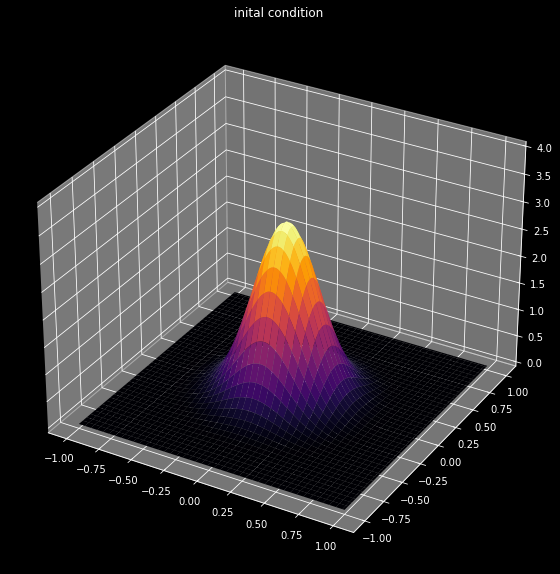

In [98]:
from IPython.display import Video

plot_3d_ic()
Video('simulations/diffusion_2d.mp4')

In [88]:
import pickle
filename_1 = 'models/2d_diffusion_model.sav'
filename_2 = 'models/2d_diffusion_results.sav'
plots = np.array([X,Y,T,p_pred_2])
pickle.dump(results ,open(filename_1, 'wb'))
pickle.dump(plots ,open(filename_2, 'wb'))

In [92]:
np.arange(len(t))

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

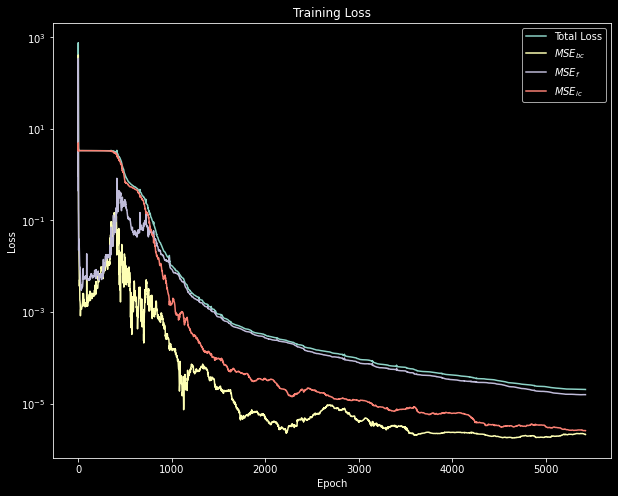

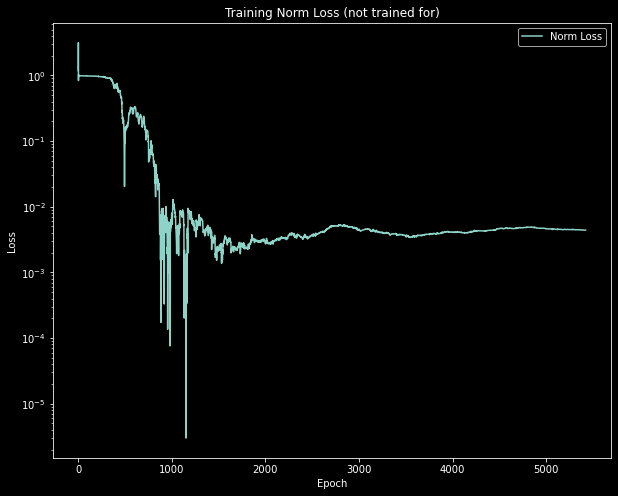

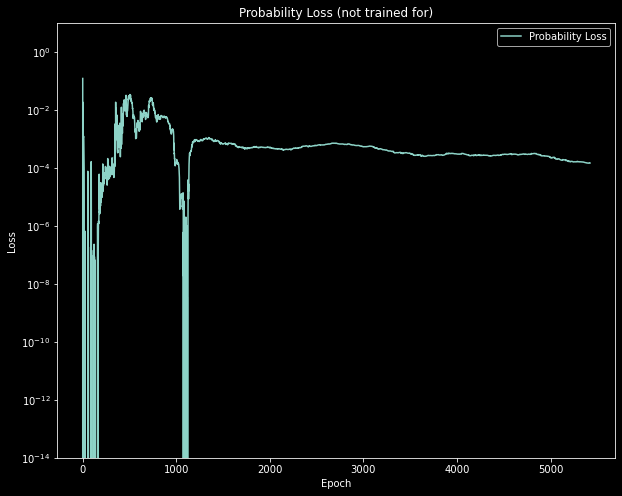

In [46]:
import pandas as pd
data_filename = "./data/TRAIN_HISTORY_IC100_BC100_f1000_t0.1_iter5000"
plt.style.use("dark_background")
plt.figure(figsize=(10,8))
plt.title("Training Loss")
df = pd.read_csv(data_filename)
plt.plot(df["epoch"], df["Total loss"], label="Total Loss")
plt.plot(df["epoch"], df["BC loss"], label="$MSE_{bc}$")
plt.plot(df["epoch"], df["f loss"], label="$MSE_f$")
plt.plot(df["epoch"], df["IC loss"], label="$MSE_{ic}$")
plt.xlabel("Epoch")
plt.ylabel("Loss")
#plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.show()

plt.figure(figsize=(10,8))
plt.title("Training Norm Loss (not trained for)")
#plt.plot(df["epoch"], df["Pr loss"], label = "Probability Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(df["epoch"], df["Norm loss"], label = "Norm Loss")
plt.yscale("log")
plt.legend()
plt.show()

plt.figure(figsize=(10,8))
plt.title("Probability Loss (not trained for)")
plt.plot(df["epoch"], df["Pr loss"], label = "Probability Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.yscale("log")
plt.ylim((10 ** -14, 10 ** 1))
plt.legend()
plt.show()